In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import bambi as bmb
import arviz as az
az.rcParams['stats.ci_prob'] = .95
from os import listdir, makedirs
import pickle
import ast

import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Data and figure path
DATA_PATH = '../data'
TRANSITION_RESULTS_PATH = '../results/transition-influence'
MODEL_RESULTS_PATH = '../results/model_fits.csv'
MODEL_REPRESENATIONS_PATH = '../results/fit_agent_representations'
FIG_PATH = '../figs'
makedirs(FIG_PATH, exist_ok=True)

# Subjects to exclude based on preregistered criterion
IDS_TO_EXCLUDE = [929094, 297827, 835395, 123289, 941076, 786858, 209368, 385852, 988204, 586980]

# Start -> Terminal for each condition
BETWEEN_ORDER = [2,3,0,1] # incongruent = between category
WITHIN_ORDER = [0,1,2,3]  # congruent = within category

CONDITION_COLORS = [
    '#FBAF00', # incongruent
    '#00AF54'  # congruent
]

TRANSITION_COLORS = {
    'spurious': '#FF0000', # spurious
    'causal': '#FFC100'    # causal
}

FREQUENCY_COLORS = [
    '#006C3E', # infrequent
    '#51DBA0'  # frequent
]

NOVELTY_COLORS = [
    '#32006b', # novel
    '#9251db'  # old
]

MODEL_COLORS = {
    'null': 'grey',
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
    
}
MODEL_LABELS = [
    'Null',
    'Conjunctive',
    'Conjunctive (Sampler)',
    'Feature-based',
]

# Helper Functions

In [3]:
def info_from_fname(fname, field):
    """
    Get information from fname using field key

    Arguments
    ---------
    fname : str
        File name
    field : str
        Field key to get value for
    
    Returns
    -------
    field_value : str
        Value for specified field
    """
    key_vals = [
        (f.split('-')[0], '-'.join(f.split('-')[1:]))
        for f in fname.split('.')[0].split('_')
        ]
    fname_info = {key: val for key, val in key_vals}
    field_value = fname_info[field]
    return field_value

def load_from_dir(path, na_values=[]):
    df = []
    for f in listdir(path):
        if '.csv' in f:
            df.append(pd.read_csv(f'{path}/{f}', na_values=na_values))
    df = pd.concat(df)
    return df

def convert_str_to_array(array_string):
    array_string = array_string.replace(' ', ',')
    arr = ast.literal_eval(array_string)
    arr = np.array(arr)
    return arr

def conver_str_to_array_list(arr):
    return [convert_str_to_array(string) for string in arr]

def add_recoded_target_column(df):
    target_recoded = []
    target_recoded_str = []
    for i, target in enumerate(df['target_arr']):
        if df.loc[i, 'between_cond']:
            target = target[[2,3,0,1]]
        target_recoded.append(target)
        target_recoded_str.append(str(target))
    df['target_recoded_arr'] = target_recoded
    df['target_recoded'] = target_recoded_str
    return df

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')
    
    
def add_block_col(df):
    """
    Add block column to data frame, and trial number by block
    
    Arguments
    ---------
    df : pandas.DataFrame
        data frame to add block to
        
    Returns
    -------
    None
    """

    # Label block
    df['block'] = (df['t'] > np.max(df['t'])/2 ).astype(int) + 1

    # Label trial number within block
    df['t_block'] = df['t'].copy()
    idx = df['block'] == 2
    df.loc[idx, 't_block'] -= np.max(df.loc[np.logical_not(idx), 't'])

    # Label quarter of phase
    df['quarter'] = 4
    n_per_block = np.max(df['t_block'])
    idx = df['t'] < n_per_block/2
    df.loc[idx, 'quarter'] = 1
    idx = np.logical_not(idx) & (df['block'] == 1)
    df.loc[idx, 'quarter'] = 2
    idx = (df['t_block'] < n_per_block/2) & (df['block'] == 2)
    df.loc[idx, 'quarter'] = 3
    
def drop_invalid_data(df, excluded_ids=[]):
    """
    Drop invalid data (excluded IDs and missed trials)
    
    Arguments
    ---------
    df : pandas.DataFrame
        data frame to drop data from
    excluded_ids : list
        list of IDs to exclude
        
    Returns
    -------
    None
    """
    
    # Excluded subjects
    df = df.loc[np.isin(df['id'], excluded_ids, invert=True)]
    df = df.reset_index(drop=True)
    
    # Missed choices
    if 'action' in df.columns:
        df = df.loc[df['action'] != -1]

def convert_state_str(state_str):
    """
    Convert a string representation of a state to a numpy array.

    Arguments
    ---------
    state_str : str
        The string representation of the state.

    Returns
    -------
    state_arr : numpy.ndarray
        The numpy array representation of the state
    """
    state_str = state_str[1:-1].split(' ')
    state_arr = np.array(state_str, dtype=int)
    return state_arr
        
def get_frequent_targets(df):
    df['freq'] = 0
    idx = (
        (df['target'] == '[1 4 0 0]') |
        (df['target'] == '[4 1 0 0]') |
        (df['target'] == '[0 0 1 4]') |
        (df['target'] == '[0 0 4 1]') 
    )
    df.loc[idx, 'freq'] = 1


def get_n_transitions_to_target(df):
    
    n_transitions_to_target = []
    for i in range(len(df)):

        # Get feature combinations
        target_comb = df.loc[i, 'target_comb']
        options_comb = df.loc[i, 'options_comb']

        # Redefine options feature definition do that transitions
        # are all "within" feature
        if df.loc[i, 'between_cond'] == 1:
            feat_order = BETWEEN_ORDER
        else:
            feat_order = WITHIN_ORDER

        # Find present features
        target_f_present = convert_state_str(target_comb)
        options_f_present = convert_state_str(options_comb)
        options_f_present = options_f_present[feat_order]

        # Get feature overlap
        overlap = np.sum(target_f_present & options_f_present)
        n_transitions_to_target.append(overlap)
        
    n_transitions_to_target = np.array(n_transitions_to_target, dtype=int)
    
    return n_transitions_to_target

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def plot_hdi(
        ax,
        posterior,
        label = False,
        label_loc = 'left',
        color = 'k',
        chance_color = 'red',
        xlim = False
    ):
    hdi = az.hdi(posterior)
    sns.kdeplot(
        posterior,
        color='white',
        fill = True,
        lw=.5,
        alpha=1,
        #bw_adjust=.5,
        ax=ax
    )
    sns.kdeplot(
        posterior,
        color='k',
        lw=.5,
        #bw_adjust=.5,
        ax=ax
    )
    sns.kdeplot(
        posterior,
        color = color,
        #bw_adjust=.5,
        clip=hdi,
        fill=True,
        lw=1,
        edgecolor='k',
        alpha=1,
        ax=ax
    )

    
    ax.set_yticks([])
    ax.set_ylabel(None)
    if label:
        ax.set_title(label, fontsize = 7, pad = 3, loc=label_loc)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_xticks([])
    #ax.set_xticklabels(ax.get_xticks(), fontsize=6)
    #ax.axvline(0, color='k', linestyle='-', linewidth=3, zorder=0)
    ax.axvline(0, color=chance_color, linestyle='-')
    ax.set_facecolor((1, 1, 1, 0))
    #ax.set_facecolor('.7')

def data_summary(df, group_vars, y_var, x_var='1', seed=0, fname=False):
    """
    Get mean and 95% HDI of Bayesian models based on group variables.
    
    Arguments
    ---------
    df : pd.DataFrame
        Data frame to summarize.
    group_vars : list
        List of variables to group by.
    y_var : str
        Dependent variable.
    x_var : str
        Independent variable. If '1', then only an intercept is fit.
    seed : int
        Random seed for reproducibility.
    fname : str
        File name to load/save results.

    Returns
    -------
    summaries : dict
        Dictionary of group variable combinations and their summaries.
    """

    # Check if saved results already exist
    if fname:
        try:
            with open(fname, 'rb') as f:
                summaries = pickle.load(f)
            return summaries
        except FileNotFoundError:
            pass
    
    # Compute summaries
    summaries = {}
    group_combs = np.array(df[group_vars].drop_duplicates())
    for comb in group_combs:

        # Fit model
        idx = np.all(df[group_vars] == comb, axis=1)
        model = bmb.Model(f'{y_var} ~ {x_var}', df.loc[idx])
        fitted = model.fit(random_seed=seed)

        # Generate HDI from posterior predictions
        post_intercept = fitted.posterior['Intercept'].values.flatten()
        if x_var == '1':
            post_slope = np.zeros(len(post_intercept))
            x = 0
        else:
            post_slope = fitted.posterior[x_var].values.flatten()
            x = np.unique(df.loc[idx, x_var])
        post_preds = np.array([
            intercept + slope*x
            for intercept, slope in zip(post_intercept, post_slope)
        ])
        hdi = az.hdi(post_preds)

        # Get mean point or line prediction
        pred_mean = np.mean(post_intercept)
        if x_var == '1':
            pred_mean = [0, pred_mean]
        else:
            x_range = np.array([np.min(x), np.max(x)])
            pred_mean += np.mean(post_slope)*x_range
            pred_mean = [x_range, pred_mean]

        # Get mean and 95% HDI of posterior predictions
        post_summary = {
            'mean': pred_mean,
            'hdi': hdi
        }
        
        # Add to summaries
        if len(group_vars) > 1:
            key = tuple(comb)
        else:
            key = comb[0]
        summaries[key] = post_summary

    # Save results
    if fname:
        if '/' in fname:
            makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        with open(fname, 'wb') as f:
            pickle.dump(summaries, f)

    return summaries


def unpack_summary_timeseries(stats_summary):
    """
    Unpack summary stats for time series data.

    Arguments
    ---------
    stats_summary : dict
        Dictionary of summary stats.
    
    Returns
    -------
    series : dict
        Dictionary of unpacked summary timeseries stats.
    """

    # Initialize dictionary to store summary stats
    series = {}
    levels = np.unique(np.array(list(stats_summary.keys()))[:, :-1], axis=0)
    for level in levels:
        series[*level, 'mean'] = []
        series[*level, 'hdi'] = []
        series[*level, 'x'] = []

    # Unpack mean and HDI for each level
    for key in stats_summary.keys():
        if len(key) > 2:
            series_key = [str(k) for k in key[:-1]]
        else:
            series_key = key[:-1]
        series[*series_key, 'mean'].append(stats_summary[key]['mean'][1])
        series[*series_key, 'hdi'].append(stats_summary[key]['hdi'])
        series[*series_key, 'x'].append(key[-1])

    # Store as array
    for key in series.keys():
        series[key] = np.array(series[key])

    # Sort values by x
    for level in levels:
        idx = np.argsort(series[*level, 'x']) 
        series[*level, 'mean'] = series[*level, 'mean'][idx]
        series[*level, 'hdi'] = series[*level, 'hdi'][idx]
        series[*level, 'x'] = series[*level, 'x'][idx]

    return series

def plot_by_categorical(
        df,
        x_var,
        y_var,
        x_label = None,
        y_label = None,
        x_tick_labels = [],
        y_lim = None,
        palette = None,
        chance = 1,
        summary_fname = False,
        fname = False,
        posterior = [],
        posterior_config = {}
        ):
    
    # Average y for each participant and grouping x variable
    plot_df = df[['id', x_var,  y_var]]
    plot_df = plot_df.groupby(['id', x_var])
    plot_df = plot_df.mean()
    plot_df = plot_df.reset_index()
    
    # Get mean and 95% HDI 
    summary = data_summary(
        plot_df,
        [x_var],
        y_var,
        seed = 2334,
        fname = summary_fname
    )
    
    fig, ax = plt.subplots(figsize=(2.5, 3))

    # Plot data
    ax.axhline(.5, color='black', linestyle='--')
    sns.swarmplot(
        data = plot_df,
        x = x_var,
        y = y_var,
        palette = palette,
        order = [1, 0],
        s = 3,
        zorder = 0
    )

    # Plot 95% HDI
    for i, key in enumerate(summary.keys()):
        ax.vlines(i, *summary[key]['hdi'], color='black', linewidth=3)
        ax.plot(i, summary[key]['mean'][1], 'ok', linewidth=3, markersize=7)

    # Format
    ax.set_xticklabels(x_tick_labels, fontsize=7)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    set_axis_ratio(ax, 2)

     # Inset interaction posterior plot with HDI
    if len(posterior) > 0:
        inset_ax = inset_axes(
            ax,
            width = '70%',
            height = '20%',
            bbox_to_anchor = (-.17, -.34, .95, 0.48),
            bbox_transform = ax.transAxes
        )
        plot_hdi(
            inset_ax,
            posterior.values.flatten(),
            **posterior_config
        )

    fig.tight_layout()
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    

def plot_by_condition_and_categorical(
        df,
        x_var,
        y_var,
        title = None,
        x_label = None,
        y_label = None,
        x_tick_labels = [], 
        y_lim = None,
        chance = 1,
        summary_fname = False,
        fname = False,
        posterior = [],
        posterior_config = {},
        bbox_to_anchor = (.03, -.34, .95, 0.48)
        ):
    """
    Plot by condition and some categorical variable.

    Arguments
    ---------
    df : pd.DataFrame
        Data frame to plot.
    x_var : str
        Categorical variable to plot on x-axis with condition
    y_var : str
        Variable to plot of the y axis
    title : str
        Plot title
    x_label : str
        Label for x-axis.
    y_label : str
        Label for y-axis.
    x_tick_labels : list
        List of x-tick labels.
    summary_fname : str
        File name to save/load summary stats.
    fname : str
        File name to save plot.
    posterior : np.array
        Posterior values to plot.
    posterior_config : dict
        Configuration for posterior plot (plot_hdi).
    bbox_to_anchor : tuple
        Position of posterior bbox

    Returns
    -------
    None
    """
    
    # Average y for each participant and grouping x variable
    plot_df = df[['id', x_var, 'sem_congruent', y_var]]
    plot_df = plot_df.groupby(['id', x_var, 'sem_congruent'])
    plot_df = plot_df.mean()
    plot_df = plot_df.reset_index()
    
    # Get mean and 95% HDI timeseries
    summary = data_summary(
        plot_df,
        ['sem_congruent', x_var],
        y_var,
        seed = 2334,
        fname = summary_fname
    )

    # Group by condition and frequency for x-tick label
    plot_df['group'] = plot_df['sem_congruent']*2 + plot_df[x_var]

    fig, ax = plt.subplots(figsize=(2.5, 3))

    ax.axhline(chance, c='.5', linestyle='--')
    sns.lineplot(
        data = plot_df,
        x = 'group',
        y = y_var,
        hue = 'id',
        palette = condition_id_palette,
        linewidth = 1,
        ax = ax
    )

    # Plot 95% HDI
    for i, key in enumerate(summary.keys()):
        x = key[0]*2 + key[1]
        ax.vlines(x, *summary[key]['hdi'], color='black', linewidth=3)
        
    # Plot means 
    for cond in [0, 1]:
        x = np.array([0, 1]) + cond*2
        y = np.array([
            summary[cond, 0]['mean'][1],
            summary[cond, 1]['mean'][1],
        ])
        ax.plot(x, y, '-ok', linewidth=3, markersize=7)

    # Format main axis
    ax.set_xlim([np.min(np.unique(plot_df['group'])) - .5, np.max(np.unique(plot_df['group'])) + .5])
    ax.get_legend().remove()
    ax.set_xticks(np.unique(plot_df['group']))
    ax.set_xticklabels(x_tick_labels*2, fontsize=7)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax, 2)

    # Inset interaction posterior plot with HDI
    if len(posterior) > 0:
        inset_ax = inset_axes(
            ax,
            width = '70%',
            height = '20%',
            bbox_to_anchor = bbox_to_anchor,
            bbox_transform = ax.transAxes
        )
        plot_hdi(
            inset_ax,
            posterior.values.flatten(),
            **posterior_config
        )

    fig.tight_layout()
    if fname:
        fig.savefig(fname, bbox_inches='tight')

def plot_by_categorical(
        df,
        x_var,
        y_var,
        title = None,
        x_label = None,
        y_label = None,
        x_tick_labels = [], 
        y_lim = None,
        chance = 1,
        summary_fname = False,
        fname = False,
        posterior = [],
        posterior_config = {},
        bbox_to_anchor = (.03, -.34, .95, 0.48),
        palette = None
        ):
    """
    Plot by some categorical variable.

    Arguments
    ---------
    df : pd.DataFrame
        Data frame to plot.
    x_var : str
        Categorical variable to plot on x-axis
    y_var : str
        Variable to plot of the y axis
    title : str
        Plot title
    x_label : str
        Label for x-axis.
    y_label : str
        Label for y-axis.
    x_tick_labels : list
        List of x-tick labels.
    summary_fname : str
        File name to save/load summary stats.
    fname : str
        File name to save plot.
    posterior : np.array
        Posterior values to plot.
    posterior_config : dict
        Configuration for posterior plot (plot_hdi).
    bbox_to_anchor : tuple
        Position of posterior bbox
    palette : str
        Palette for x-axis variable

    Returns
    -------
    None
    """
    
    # Average y for each participant and grouping x variable
    plot_df = df[['id', x_var, y_var]]
    plot_df = plot_df.groupby(['id', x_var])
    plot_df = plot_df.mean()
    plot_df = plot_df.reset_index()
    
    # Get mean and 95% HDI timeseries
    summary = data_summary(
        plot_df,
        [x_var],
        y_var,
        seed = 2334,
        fname = summary_fname
    )

    fig, ax = plt.subplots(figsize=(2.5, 3))

    ax.axhline(chance, c='.5', linestyle='--')
    sns.swarmplot(
        data = plot_df,
        x = x_var,
        y = y_var,
        hue = x_var,
        palette = CONDITION_COLORS,
        s = 2.5,
        zorder = 0
    )

    # Plot 95% HDI
    for i, key in enumerate(summary.keys()):
        ax.vlines(key, *summary[key]['hdi'], color='black', linewidth=3)
        
    # Plot means 
    for var in summary.keys():
        ax.plot(
            var,
            summary[var]['mean'][1],
            'ok',
            linewidth = 3,
            markersize = 7
        )

    # Format main axis
    ax.set_xlim([np.min(np.unique(plot_df[x_var])) - .5, np.max(np.unique(plot_df[x_var])) + .5])
    ax.set_xticks(np.unique(plot_df[x_var]))
    ax.set_xticklabels(x_tick_labels, fontsize=7)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    ax.set_title(title, loc='left')
    ax.get_legend().remove()
    set_axis_ratio(ax, 2)

    # Inset interaction posterior plot with HDI
    if len(posterior) > 0:
        inset_ax = inset_axes(
            ax,
            width = '70%',
            height = '20%',
            bbox_to_anchor = bbox_to_anchor,
            bbox_transform = ax.transAxes
        )
        plot_hdi(
            inset_ax,
            posterior.values.flatten(),
            **posterior_config
        )

    fig.tight_layout()
    if fname:
        fig.savefig(fname, bbox_inches='tight')

# Load model fits

In [4]:
model_fits_df = pd.read_csv(
    MODEL_RESULTS_PATH,
    na_values=['', 'NaN', None],
    keep_default_na = False
)
idx = np.isin(model_fits_df['id'], IDS_TO_EXCLUDE, invert=True)
model_fits_df = model_fits_df.loc[idx]
model_fits_df = model_fits_df.reset_index(drop=True)
model_fits_df = model_fits_df.drop_duplicates()
model_fits_df

,id,model_label,success,n_starts,nll,aic,alpha,beta,beta_test,segmentation,bias_learning_rate,conjunctive_starts,conjunctive_successors,conjunctive_composition,memory_sampler,sampler_feature_weight,sampler_recency_weight,sampler_specificity,alpha_decay,gamma
0,10967,ff,True,8,282.012938,570.025876,0.999900,0.012954,0.012954,0.999900,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
1,10967,null,True,0,282.804050,565.608099,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0
2,10967,ss,True,6,282.507367,569.014734,0.999900,0.034885,0.034885,0.000000,NaN,True,True,True,False,1.000000,0,1.000000,0.0,1.0
3,10967,ss-sampler,True,8,282.517118,573.034237,0.999900,0.085478,0.085478,0.000000,NaN,True,True,False,True,0.500000,0,1.380828,0.0,1.0
4,11586,ff,True,8,273.348189,552.696378,0.000213,23493.394610,23493.394610,0.999899,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,993903,ss-sampler,True,8,286.291376,580.582752,0.024390,36.358068,36.358068,0.000000,NaN,True,True,False,True,1.000000,0,211.542612,0.0,1.0
396,994721,ff,True,8,260.041752,526.083504,0.976448,0.052217,0.052217,0.666369,NaN,False,False,False,False,1.000000,0,1.000000,0.0,1.0
397,994721,null,True,0,270.327400,540.654801,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0
398,994721,ss,True,7,266.960790,537.921580,0.999900,0.049678,0.049678,0.000000,NaN,True,True,True,False,1.000000,0,1.000000,0.0,1.0


## Get best fitting models

In [5]:
model_fits_df['best_fit'] = 0
for subj in np.unique(model_fits_df['id']):
    idx = model_fits_df['id'] == subj
    subj_fits = model_fits_df.loc[idx]
    
    # Get best fitting model
    min_aic = np.argmin(subj_fits['aic'])
    subj_fits['best_fit'] = np.eye(np.sum(idx), dtype=int)[min_aic]    
    model_fits_df.loc[idx] = subj_fits

# Select the best fits
idx = model_fits_df['best_fit'] == 1
best_fits = model_fits_df.loc[idx]

# Label if the feature-based model is best fitting
best_fits['ff_fit'] = best_fits['model_label'] == 'ff'
best_fits['ff_fit'] = best_fits['ff_fit'].astype(int)

best_fits

,id,model_label,success,n_starts,nll,aic,alpha,beta,beta_test,segmentation,...,conjunctive_successors,conjunctive_composition,memory_sampler,sampler_feature_weight,sampler_recency_weight,sampler_specificity,alpha_decay,gamma,best_fit,ff_fit
1,10967,null,True,0,282.804050,565.608099,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1,0
5,11586,null,True,0,274.486284,548.972567,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1,0
9,29828,null,True,0,291.121816,582.243632,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1,0
12,30579,ff,True,7,260.848399,527.696798,0.704705,0.194427,0.194427,0.000000,...,False,False,False,1.000000,0,1.000000,0.0,1.0,1,1
17,32161,null,True,0,270.327400,540.654801,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,974361,ss-sampler,True,7,273.670901,555.341803,0.999900,81.580382,81.580382,0.000000,...,True,False,True,0.003504,0,1.418997,0.0,1.0,1,0
384,978218,ff,True,7,219.122062,444.244124,0.999900,0.158474,0.158474,0.874131,...,False,False,False,1.000000,0,1.000000,0.0,1.0,1,1
389,991406,null,True,0,281.417755,562.835511,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1.000000,-1,-1.000000,-1.0,-1.0,1,0
395,993903,ss-sampler,True,8,286.291376,580.582752,0.024390,36.358068,36.358068,0.000000,...,True,False,True,1.000000,0,211.542612,0.0,1.0,1,0


# Load data

In [6]:
# Load data
training_df = load_from_dir(f'{DATA_PATH}/training', na_values='null')
add_block_col(training_df)
training_df = training_df.loc[training_df['valid_response'] == 1]
training_df = training_df.reset_index(drop=True)

# Frequent versus infrequent targets
get_frequent_targets(training_df)

# Exclude participants
idx = np.isin(training_df['id'], IDS_TO_EXCLUDE, invert=True)
training_df = training_df.loc[idx]
training_df = training_df.reset_index(drop=True)

# Add best fitting model
training_df = pd.merge(
    training_df,
    best_fits[['id', 'model_label', 'segmentation']]
)

# Convert state columns
training_df['target_arr'] = conver_str_to_array_list(training_df['target'])
training_df['options_arr'] = conver_str_to_array_list(training_df['options'])
training_df['composition_arr'] = conver_str_to_array_list(training_df['composition'])

# Create column of recoded targets where features correspond not to stimulus features
# but to whether instances transition to each other or not
training_df = add_recoded_target_column(training_df)

# Compute cumulative reward
training_df = training_df.sort_values(['id', 't'])
training_df = training_df.reset_index(drop=True)
training_df['cumulative_reward'] = training_df.groupby(
    'id')['reward'].cumsum()

# Compute cumulative reward by block
training_df = training_df.sort_values(['id', 't'])
training_df = training_df.reset_index(drop=True)
training_df['cumulative_reward_block'] = training_df.groupby(
    ['id', 'block'])['reward'].cumsum()

# Re-code so condition = 1 = semantic congruent
training_df['sem_congruent'] = 1 - training_df['between_cond'].astype(int)

training_df

,id,seed,between_cond,phase,t,target_comb,options_comb,options_fnames,options,correct_composition,...,model_label,segmentation,target_arr,options_arr,composition_arr,target_recoded_arr,target_recoded,cumulative_reward,cumulative_reward_block,sem_congruent
0,10967,32,1,training,7,[0 0 1 1],[1 1 0 0],"[[""img/bo-0_he-2_ar-0_an-0.png"",""img/bo-0_he-3...","[[[0,2,0,0],[0,3,0,0]],[[3,0,0,0],[2,0,0,0]]]","[0,0,1,4]",...,null,-1.0,"[0, 0, 1, 4]","[[[0, 2, 0, 0], [0, 3, 0, 0]], [[3, 0, 0, 0], ...","[3, 3, 0, 0]","[1, 4, 0, 0]",[1 4 0 0],1,1,0
1,10967,32,1,training,8,[0 0 1 1],[1 1 0 0],"[[""img/bo-3_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[3,0,0,0],[2,0,0,0]],[[0,3,0,0],[0,2,0,0]]]","[0,0,4,4]",...,null,-1.0,"[0, 0, 4, 4]","[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 3, 0, 0], ...","[2, 3, 0, 0]","[4, 4, 0, 0]",[4 4 0 0],2,2,0
2,10967,32,1,training,9,[0 0 1 1],[1 1 0 0],"[[""img/bo-0_he-3_ar-0_an-0.png"",""img/bo-0_he-2...","[[[0,3,0,0],[0,2,0,0]],[[3,0,0,0],[2,0,0,0]]]","[0,0,1,4]",...,null,-1.0,"[0, 0, 1, 4]","[[[0, 3, 0, 0], [0, 2, 0, 0]], [[3, 0, 0, 0], ...","[2, 2, 0, 0]","[1, 4, 0, 0]",[1 4 0 0],3,3,0
3,10967,32,1,training,10,[0 0 1 1],[1 1 0 0],"[[""img/bo-1_he-0_ar-0_an-0.png"",""img/bo-3_he-0...","[[[2,0,0,0],[3,0,0,0]],[[0,2,0,0],[0,3,0,0]]]","[0,0,4,4]",...,null,-1.0,"[0, 0, 4, 4]","[[[2, 0, 0, 0], [3, 0, 0, 0]], [[0, 2, 0, 0], ...","[3, 2, 0, 0]","[4, 4, 0, 0]",[4 4 0 0],4,4,0
4,10967,32,1,training,11,[0 0 1 1],[1 1 0 0],"[[""img/bo-3_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[3,0,0,0],[2,0,0,0]],[[0,2,0,0],[0,3,0,0]]]","[0,0,1,4]",...,null,-1.0,"[0, 0, 1, 4]","[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 2, 0, 0], ...","[2, 3, 0, 0]","[1, 4, 0, 0]",[1 4 0 0],6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,994721,11,0,training,68,[0 0 1 1],[0 0 1 1],"[[""img/bo-0_he-0_ar-0_an-4.png"",""img/bo-0_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,0,2,0],[0,0,3,0]]]","[0,0,3,3]",...,ss-sampler,0.0,"[0, 0, 4, 4]","[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 0, 2, 0], ...","[0, 0, 3, 3]","[0, 0, 4, 4]",[0 0 4 4],68,32,1
6962,994721,11,0,training,69,[0 0 1 1],[0 0 1 1],"[[""img/bo-6_he-0_ar-0_an-0.png"",""img/bo-2_he-0...","[[[0,0,2,0],[0,0,3,0]],[[0,0,0,3],[0,0,0,2]]]","[0,0,3,2]",...,ss-sampler,0.0,"[0, 0, 4, 1]","[[[0, 0, 2, 0], [0, 0, 3, 0]], [[0, 0, 0, 3], ...","[0, 0, 3, 3]","[0, 0, 4, 1]",[0 0 4 1],69,33,1
6963,994721,11,0,training,70,[0 0 1 1],[0 0 1 1],"[[""img/bo-6_he-0_ar-0_an-0.png"",""img/bo-2_he-0...","[[[0,0,2,0],[0,0,3,0]],[[0,0,0,2],[0,0,0,3]]]","[0,0,3,2]",...,ss-sampler,0.0,"[0, 0, 4, 1]","[[[0, 0, 2, 0], [0, 0, 3, 0]], [[0, 0, 0, 2], ...","[0, 0, 3, 2]","[0, 0, 4, 1]",[0 0 4 1],71,35,1
6964,994721,11,0,training,71,[0 0 1 1],[0 0 1 1],"[[""img/bo-2_he-0_ar-0_an-0.png"",""img/bo-6_he-0...","[[[0,0,3,0],[0,0,2,0]],[[0,0,0,3],[0,0,0,2]]]","[0,0,3,2]",...,ss-sampler,0.0,"[0, 0, 4, 1]","[[[0, 0, 3, 0], [0, 0, 2, 0]], [[0, 0, 0, 3], ...","[0, 0, 3, 2]","[0, 0, 4, 1]",[0 0 4 1],73,37,1


In [7]:
# Load data
test_df = load_from_dir(f'{DATA_PATH}/test', na_values='null')
test_df = test_df.loc[test_df['valid_response'] == 1]
test_df = test_df.reset_index(drop=True)

# Exclude participants
idx = np.isin(test_df['id'], IDS_TO_EXCLUDE, invert=True)
test_df = test_df.loc[idx]
test_df = test_df.reset_index(drop=True)

# Frequent versus infrequent targets during training
get_frequent_targets(test_df)

# Get novel targets and options
test_df['novel_target'] = np.logical_not(
    (test_df['target_comb'] == '[1 1 0 0]') |
    (test_df['target_comb'] == '[0 0 1 1]')
)
test_df['novel_options'] = np.logical_not(
    (test_df['options_comb'] == '[1 1 0 0]') |
    (test_df['options_comb'] == '[0 0 1 1]')
)

# Get number of possible transitions to the target
test_df['n_transitions_to_target'] = get_n_transitions_to_target(test_df)

# Get old (from training) trials
test_df['old'] = (
    np.logical_not(test_df['novel_options'] | test_df['novel_target']) &
    (test_df['n_transitions_to_target'] == 2)
)

# Add best fitting model
test_df = pd.merge(
    test_df,
    best_fits[['id', 'model_label', 'segmentation']]
)

# Convert state columns
test_df['target_arr'] = conver_str_to_array_list(test_df['target'])
test_df['options_arr'] = conver_str_to_array_list(test_df['options'])
test_df['composition_arr'] = conver_str_to_array_list(test_df['composition'])

# Create column of recoded targets where features correspond not to stimulus features
# but to whether instances transition to each other or not
test_df = add_recoded_target_column(test_df)

# Get chance reward on trials with possible valid causal inferences
idx = test_df['n_transitions_to_target'] != 0
test_trials_df = test_df.loc[idx, [
    'target',
    'options_comb',
    'n_transitions_to_target'
]]
test_trials_df = test_trials_df.drop_duplicates()
test_trials_df = test_trials_df.reset_index(drop=True)
test_chance_reward = np.mean(test_trials_df['n_transitions_to_target']/2)

# Re-code so condition = 1 = semantic congruent
test_df['sem_congruent'] = 1 - test_df['between_cond'].astype(int)
        
test_df

,id,seed,between_cond,phase,t,target_comb,options_comb,options_fnames,options,correct_composition,...,n_transitions_to_target,old,model_label,segmentation,target_arr,options_arr,composition_arr,target_recoded_arr,target_recoded,sem_congruent
0,548688,13,0,test,1,[0 0 1 1],[1 0 0 1],"[[""img/bo-0_he-3_ar-0_an-0.png"",""img/bo-0_he-6...","[[[3,0,0,0],[2,0,0,0]],[[0,0,0,2],[0,0,0,3]]]","[0,0,4,4]",...,1,False,ff,0.9999,"[0, 0, 4, 4]","[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 0, 0, 2], ...","[3, 0, 0, 3]","[0, 0, 4, 4]",[0 0 4 4],1
1,548688,13,0,test,2,[1 1 0 0],[1 0 0 1],"[[""img/bo-0_he-3_ar-0_an-0.png"",""img/bo-0_he-6...","[[[3,0,0,0],[2,0,0,0]],[[0,0,0,2],[0,0,0,3]]]","[1,4,0,0]",...,1,False,ff,0.9999,"[1, 4, 0, 0]","[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 0, 0, 2], ...","[3, 0, 0, 3]","[1, 4, 0, 0]",[1 4 0 0],1
2,548688,13,0,test,3,[0 1 0 1],[0 1 1 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[0,0,2,0],[0,0,3,0]]]","[0,4,0,1]",...,1,False,ff,0.9999,"[0, 4, 0, 1]","[[[0, 3, 0, 0], [0, 2, 0, 0]], [[0, 0, 2, 0], ...","[0, 2, 2, 0]","[0, 4, 0, 1]",[0 4 0 1],1
3,548688,13,0,test,4,[1 0 1 0],[1 1 0 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[3,0,0,0],[2,0,0,0]]]","[4,0,4,0]",...,1,False,ff,0.9999,"[4, 0, 4, 0]","[[[0, 3, 0, 0], [0, 2, 0, 0]], [[3, 0, 0, 0], ...","[3, 2, 0, 0]","[4, 0, 4, 0]",[4 0 4 0],1
4,548688,13,0,test,5,[0 1 0 1],[1 1 0 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[2,0,0,0],[3,0,0,0]]]","[0,1,0,4]",...,1,False,ff,0.9999,"[0, 1, 0, 4]","[[[0, 3, 0, 0], [0, 2, 0, 0]], [[2, 0, 0, 0], ...","[3, 2, 0, 0]","[0, 1, 0, 4]",[0 1 0 4],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14147,320762,15,0,test,140,[1 1 0 0],[0 0 1 1],"[[""img/bo-0_he-0_ar-1_an-0.png"",""img/bo-0_he-0...","[[[0,0,3,0],[0,0,2,0]],[[0,0,0,3],[0,0,0,2]]]","[3,3,0,0]",...,0,False,ss-sampler,0.0000,"[4, 4, 0, 0]","[[[0, 0, 3, 0], [0, 0, 2, 0]], [[0, 0, 0, 3], ...","[0, 0, 3, 3]","[4, 4, 0, 0]",[4 4 0 0],1
14148,320762,15,0,test,141,[0 1 1 0],[0 0 1 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,0,2,0],[0,0,3,0]]]","[0,2,3,0]",...,1,False,ss-sampler,0.0000,"[0, 1, 4, 0]","[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 0, 2, 0], ...","[0, 0, 3, 2]","[0, 1, 4, 0]",[0 1 4 0],1
14149,320762,15,0,test,142,[1 0 0 1],[0 0 1 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,0,3,0],[0,0,2,0]]]","[2,0,0,3]",...,1,False,ss-sampler,0.0000,"[1, 0, 0, 4]","[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 0, 3, 0], ...","[0, 0, 2, 3]","[1, 0, 0, 4]",[1 0 0 4],1
14150,320762,15,0,test,143,[0 0 1 1],[0 1 0 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,2,0,0],[0,3,0,0]]]","[0,0,4,1]",...,1,False,ss-sampler,0.0000,"[0, 0, 4, 1]","[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 2, 0, 0], ...","[0, 2, 0, 2]","[0, 0, 4, 1]",[0 0 4 1],1


In [8]:
test_df['comp_spur_pred'] = 0
test_df['spurious_trial'] = 0
test_df['causal_trial'] = 0

for i in range(len(test_df)):
    
    # Get recoded target and composition arrays for this trial
    target = test_df.loc[i, 'target_recoded_arr']
    composition = test_df.loc[i, 'composition_arr']

    # Get the options and target feature combinations based on this
    target_comb = target != 0
    options_comb = composition != 0
    spur_options_comb = options_comb[[1,0,3,2]]
    
    # Next, get what the most spuriously predictive composition would be for this target
    spur_pred_composition = np.copy(target)
    
    # (1) instance values flip for this
    # i.e., 2 -> 4 and 3 -> 1, not 2 -> 1 and 3 -> 4
    spur_pred_composition[spur_pred_composition == 4] = 2
    spur_pred_composition[spur_pred_composition == 1] = 3
    
    # (2) spurious is across-features, so recode feature again
    spur_pred_composition = spur_pred_composition[[1,0,3,2]]
    
    
    # To what extent do the causal and ideal spuriously composition match?
    feature_match = (
        (composition == spur_pred_composition) &
        (composition != 0)
    )
    test_df.loc[i, 'comp_spur_pred'] = np.sum(feature_match)


    # Label trials where only an spuriously predictive inference is possible
    if (
        (
            np.all(target_comb == np.array([1,0,1,0])) and
            np.all(options_comb == np.array([0,1,0,1]))
        ) or
        (
            np.all(target_comb == np.array([0,1,0,1])) and
            np.all(options_comb == np.array([1,0,1,0]))
        )
    ):
        test_df.loc[i, 'spurious_trial'] = 1
    else:
        test_df.loc[i, 'spurious_trial'] = 0

    # Label trials where only an causal predictive inference is possible
    if (
        (
            np.all(target_comb == np.array([1,0,1,0])) and
            np.all(options_comb == np.array([1,0,1,0]))
        ) or
        (
            np.all(target_comb == np.array([0,1,0,1])) and
            np.all(options_comb == np.array([0,1,0,1]))
        )
    ):
        test_df.loc[i, 'causal_trial'] = 1
    else:
        test_df.loc[i, 'causal_trial'] = 0

    # Get proportion of causal inferences that can be made
    test_df.loc[i, 'p_causal'] = np.sum(
        (target_comb == options_comb) &
        (target_comb != 0)
    )/2

    # Get proportion of spurious inferences that can be made
    test_df.loc[i, 'p_spurious'] = np.sum(
        (target_comb == spur_options_comb) &
        (target_comb != 0)
    )/2

test_df

,id,seed,between_cond,phase,t,target_comb,options_comb,options_fnames,options,correct_composition,...,options_arr,composition_arr,target_recoded_arr,target_recoded,sem_congruent,comp_spur_pred,spurious_trial,causal_trial,p_causal,p_spurious
0,548688,13,0,test,1,[0 0 1 1],[1 0 0 1],"[[""img/bo-0_he-3_ar-0_an-0.png"",""img/bo-0_he-6...","[[[3,0,0,0],[2,0,0,0]],[[0,0,0,2],[0,0,0,3]]]","[0,0,4,4]",...,"[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 0, 0, 2], ...","[3, 0, 0, 3]","[0, 0, 4, 4]",[0 0 4 4],1,0,0,0,0.5,0.5
1,548688,13,0,test,2,[1 1 0 0],[1 0 0 1],"[[""img/bo-0_he-3_ar-0_an-0.png"",""img/bo-0_he-6...","[[[3,0,0,0],[2,0,0,0]],[[0,0,0,2],[0,0,0,3]]]","[1,4,0,0]",...,"[[[3, 0, 0, 0], [2, 0, 0, 0]], [[0, 0, 0, 2], ...","[3, 0, 0, 3]","[1, 4, 0, 0]",[1 4 0 0],1,0,0,0,0.5,0.5
2,548688,13,0,test,3,[0 1 0 1],[0 1 1 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[0,0,2,0],[0,0,3,0]]]","[0,4,0,1]",...,"[[[0, 3, 0, 0], [0, 2, 0, 0]], [[0, 0, 2, 0], ...","[0, 2, 2, 0]","[0, 4, 0, 1]",[0 4 0 1],1,0,0,0,0.5,0.5
3,548688,13,0,test,4,[1 0 1 0],[1 1 0 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[3,0,0,0],[2,0,0,0]]]","[4,0,4,0]",...,"[[[0, 3, 0, 0], [0, 2, 0, 0]], [[3, 0, 0, 0], ...","[3, 2, 0, 0]","[4, 0, 4, 0]",[4 0 4 0],1,1,0,0,0.5,0.5
4,548688,13,0,test,5,[0 1 0 1],[1 1 0 0],"[[""img/bo-0_he-0_ar-4_an-0.png"",""img/bo-0_he-0...","[[[0,3,0,0],[0,2,0,0]],[[2,0,0,0],[3,0,0,0]]]","[0,1,0,4]",...,"[[[0, 3, 0, 0], [0, 2, 0, 0]], [[2, 0, 0, 0], ...","[3, 2, 0, 0]","[0, 1, 0, 4]",[0 1 0 4],1,1,0,0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14147,320762,15,0,test,140,[1 1 0 0],[0 0 1 1],"[[""img/bo-0_he-0_ar-1_an-0.png"",""img/bo-0_he-0...","[[[0,0,3,0],[0,0,2,0]],[[0,0,0,3],[0,0,0,2]]]","[3,3,0,0]",...,"[[[0, 0, 3, 0], [0, 0, 2, 0]], [[0, 0, 0, 3], ...","[0, 0, 3, 3]","[4, 4, 0, 0]",[4 4 0 0],1,0,0,0,0.0,0.0
14148,320762,15,0,test,141,[0 1 1 0],[0 0 1 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,0,2,0],[0,0,3,0]]]","[0,2,3,0]",...,"[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 0, 2, 0], ...","[0, 0, 3, 2]","[0, 1, 4, 0]",[0 1 4 0],1,1,0,0,0.5,0.5
14149,320762,15,0,test,142,[1 0 0 1],[0 0 1 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,0,3,0],[0,0,2,0]]]","[2,0,0,3]",...,"[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 0, 3, 0], ...","[0, 0, 2, 3]","[1, 0, 0, 4]",[1 0 0 4],1,1,0,0,0.5,0.5
14150,320762,15,0,test,143,[0 0 1 1],[0 1 0 1],"[[""img/bo-5_he-0_ar-0_an-0.png"",""img/bo-1_he-0...","[[[0,0,0,2],[0,0,0,3]],[[0,2,0,0],[0,3,0,0]]]","[0,0,4,1]",...,"[[[0, 0, 0, 2], [0, 0, 0, 3]], [[0, 2, 0, 0], ...","[0, 2, 0, 2]","[0, 0, 4, 1]",[0 0 4 1],1,1,0,0,0.5,0.5


## Create subject-level data frame with key model fit info

In [9]:
# Get subject and condition information
subj_df = training_df[['id', 'sem_congruent']].drop_duplicates()

# Share model fit information between data frames
model_fits_df = pd.merge(model_fits_df, subj_df)
best_fits = pd.merge(best_fits, subj_df)
subj_df = pd.merge(
    subj_df,
    best_fits[['id', 'model_label', 'segmentation', 'aic']],
)

subj_df

,id,sem_congruent,model_label,segmentation,aic
0,10967,0,null,-1.000000,565.608099
1,11586,0,null,-1.000000,548.972567
2,29828,1,null,-1.000000,582.243632
3,30579,0,ff,0.000000,527.696798
4,32161,1,null,-1.000000,540.654801
...,...,...,...,...,...
95,974361,0,ss-sampler,0.000000,555.341803
96,978218,0,ff,0.874131,444.244124
97,991406,1,null,-1.000000,562.835511
98,993903,1,ss-sampler,0.000000,580.582752


# Load transition influence results

## Training: agent-wise

In [49]:
trans_influence_df = []
for fname in listdir(f'{TRANSITION_RESULTS_PATH}/training/agent'):

    # Load trace
    with open(f'{TRANSITION_RESULTS_PATH}/training/agent/{fname}', 'rb') as f:
        trace = pickle.load(f)

    # Extract coefficients
    coefs = az.summary(trace)['mean'].values
    coefs = coefs.reshape(-1, 2)

    # Add to full results set
    coefs_df = pd.DataFrame({
        'id': info_from_fname(fname, 'agent'),
        'action': [1, 2, 3],
        'spurious': coefs[:, 0],
        'causal': coefs[:, 1]
    })
    trans_influence_df.append(coefs_df)

# Combine into one data frame
trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Format
trans_influence_df['id'] = trans_influence_df['id'].astype(int)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['id', 'action'],
    value_vars = ['spurious', 'causal'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = 'id'
)

# Get mean influence across action
mean_trans_influence_df = trans_influence_df[[*subj_df.columns, 'transition', 'coef']]
mean_trans_influence_df = mean_trans_influence_df.groupby([*subj_df.columns, 'transition'], dropna=False)
mean_trans_influence_df = mean_trans_influence_df.mean()
mean_trans_influence_df = mean_trans_influence_df.reset_index()

# Recode so spurious = 0 factor
trans_influence_df['transition'] = pd.Categorical(
    trans_influence_df['transition'],
    categories = ['spurious', 'causal'],
    ordered = True
)

# Recode so spurious = 0 factor
mean_trans_influence_df['transition'] = pd.Categorical(
    mean_trans_influence_df['transition'],
    categories = ['spurious', 'causal'],
    ordered = True
)
 
trans_influence_df

,id,sem_congruent,model_label,segmentation,aic,transition,coef
0,10967,0,null,-1.0,565.608099,causal,0.547667
1,10967,0,null,-1.0,565.608099,spurious,-0.580333
2,11586,0,null,-1.0,548.972567,causal,-0.291000
3,11586,0,null,-1.0,548.972567,spurious,-0.720333
4,29828,1,null,-1.0,582.243632,causal,-0.552667
...,...,...,...,...,...,...,...
195,991406,1,null,-1.0,562.835511,spurious,-0.155667
196,993903,1,ss-sampler,0.0,580.582752,causal,1.088333
197,993903,1,ss-sampler,0.0,580.582752,spurious,0.115667
198,994721,1,ss-sampler,0.0,503.522277,causal,0.994333


## Training: trial-wise

In [37]:
trans_influence_trial_df = []
for fname in listdir(f'{TRANSITION_RESULTS_PATH}/training/trial'):
    if fname[0] == '.':
        continue

    # Load trace
    with open(f'{TRANSITION_RESULTS_PATH}/training/trial/{fname}', 'rb') as f:
        trace = pickle.load(f)

    # Extract coefficients
    coefs = az.summary(trace)['mean'].values
    coefs = coefs.reshape(-1, 2)

    # Add to full results set
    coefs_df = pd.DataFrame({
        't': info_from_fname(fname, 'trial'),
        'sem_congruent': 1 - int(info_from_fname(fname, 'condition')),
        'action': [1, 2, 3],
        'spurious': coefs[:, 0],
        'causal': coefs[:, 1]
    })
    trans_influence_trial_df.append(coefs_df)

# Combine into one data frame
trans_influence_trial_df = pd.concat(trans_influence_trial_df)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Format
trans_influence_trial_df['t'] = trans_influence_trial_df['t'].astype(int)
trans_influence_trial_df['sem_congruent'] = trans_influence_trial_df['sem_congruent'].astype(int)

# Convert to long
trans_influence_trial_df = pd.melt(
    trans_influence_trial_df,
    id_vars = ['t', 'sem_congruent', 'action'],
    value_vars = ['spurious', 'causal'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Recode so spurious = 0 factor
trans_influence_trial_df['transition'] = pd.Categorical(
    trans_influence_trial_df['transition'],
    categories = ['spurious', 'causal'],
    ordered = True
)

# Add block info
trans_influence_trial_df = pd.merge(
    trans_influence_trial_df,
    training_df[['t', 'block', 't_block', 'quarter']].drop_duplicates()
)

# Compute the cumulative transition influence per agent
trans_influence_trial_df = trans_influence_trial_df.sort_values(
    by = ['sem_congruent', 'transition', 't', 'action']
    )
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)
trans_influence_trial_df['cumulative_coef'] = trans_influence_trial_df.groupby(
    ['sem_congruent', 'transition', 'action']
    )['coef'].cumsum()

# Compute the cumulative transition influence per agent and block
trans_influence_trial_df = trans_influence_trial_df.sort_values(
    by = ['sem_congruent', 'transition', 'block', 't', 'action']
    )
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)
trans_influence_trial_df['cumulative_coef_block'] = trans_influence_trial_df.groupby(
    ['sem_congruent', 'transition', 'block', 'action']
    )['coef'].cumsum()

trans_influence_trial_df

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/791472108.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans_influence_trial_df['cumulative_coef'] = trans_influence_trial_df.groupby(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/791472108.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans_influence_trial_df['cumulative_coef_block'] = trans_influence_trial_df.groupby(


,t,sem_congruent,action,transition,coef,block,t_block,quarter,cumulative_coef,cumulative_coef_block
0,2,0,1,spurious,-2.819,1,2,1,-2.819,-2.819
1,2,0,2,spurious,1.855,1,2,1,1.855,1.855
2,2,0,3,spurious,0.113,1,2,1,0.113,0.113
3,3,0,1,spurious,0.101,1,3,1,-2.718,-2.718
4,3,0,2,spurious,-1.763,1,3,1,0.092,0.092
...,...,...,...,...,...,...,...,...,...,...
835,71,1,2,causal,4.542,2,35,4,120.287,82.775
836,71,1,3,causal,2.715,2,35,4,115.543,73.999
837,72,1,1,causal,2.905,2,36,4,116.809,84.930
838,72,1,2,causal,3.581,2,36,4,123.868,86.356


# Color palette

In [10]:
# Make color palette
id_palette = sns.color_palette('tab20', n_colors=len(subj_df))
id_palette = dict(zip(subj_df['id'], id_palette))

# Make condition palette per ID
condition_id_palette = {}
for subj, cond in np.array(subj_df[['id', 'sem_congruent']]):
    condition_id_palette[subj] = CONDITION_COLORS[cond]
    
# Make model palette per ID
model_id_palette = {}
for subj, model_label in np.array(subj_df[['id', 'model_label']]):
    model_id_palette[subj] = MODEL_COLORS[model_label]

# Performance

## Cumulative training reward by condition

In [21]:
model_e1 = bmb.Model(
    "cumulative_reward ~ t*block*sem_congruent + (1|id)",
    training_df[['id', 't', 'block', 'sem_congruent', 'cumulative_reward']],
    family = 'gaussian',
    link = 'identity'
)
fitted_e1 = model_e1.fit(
    random_seed = 1
)
az.summary(fitted_e1)[-10:]

Output()

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|id_sigma,11.894,0.821,10.241,13.445,0.088,0.062,86.0,250.0,1.05
Intercept,2.051,2.076,-1.644,6.293,0.240,0.170,76.0,231.0,1.05
block,-5.099,0.983,-7.048,-3.222,0.044,0.032,490.0,862.0,1.01
block:sem_congruent,-2.454,1.402,-5.111,0.381,0.065,0.046,456.0,948.0,1.01
sem_congruent,0.920,2.997,-4.784,7.156,0.322,0.229,89.0,134.0,1.04
sigma,7.231,0.061,7.110,7.350,0.001,0.001,1805.0,2473.0,1.00
t,1.149,0.039,1.077,1.227,0.002,0.001,441.0,810.0,1.01
t:block,0.113,0.024,0.066,0.160,0.001,0.001,401.0,680.0,1.01
t:block:sem_congruent,0.078,0.034,0.012,0.146,0.002,0.001,376.0,812.0,1.01
t:sem_congruent,-0.061,0.056,-0.172,0.043,0.003,0.002,414.0,933.0,1.01


In [19]:
# Get mean and 95% HDI timeseries
cumulative_reward_summary = data_summary(
    training_df[['id', 'sem_congruent', 't', 'cumulative_reward']],
    ['sem_congruent', 't'],
    'cumulative_reward',
    seed = 2334,
    fname = f'{FIG_PATH}/stats/cumulative_reward_summary.pkl'
)

# Reformat for plotting
stats_series = unpack_summary_timeseries(cumulative_reward_summary)

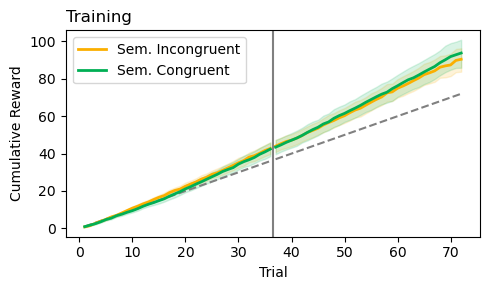

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.axvline(int(72/2) + .5, c='.5')
plt.plot([1, 36], [1, 36], '--', c='.5')
plt.plot([37, 72], [37, 72], '--', c='.5')

for condition in [0, 1]:
    for block in [1, 2]:
        if block == 1:
            idx = stats_series[condition, 'x'] <= np.max(stats_series[condition, 'x'])/2
        else:
            idx = stats_series[condition, 'x'] > np.max(stats_series[condition, 'x'])/2
        ax.fill_between(
            stats_series[condition, 'x'][idx],
            stats_series[condition, 'hdi'][:, 0][idx],
            stats_series[condition, 'hdi'][:, 1][idx],
            color = CONDITION_COLORS[condition],
            alpha = .15
        )
        ax.plot(
            stats_series[condition, 'x'][idx],
            stats_series[condition, 'mean'][idx],
            color = CONDITION_COLORS[condition],
            label = condition,
            linewidth = 2
        )

handles = ax.get_legend_handles_labels()[0]
ax.set_title('Training', loc='left')
ax.legend(handles[1:-1], ['Sem. Incongruent', 'Sem. Congruent'])
ax.set_xlabel('Trial')
ax.set_ylabel('Cumulative Reward')
fig.tight_layout()

plt.savefig(f'{FIG_PATH}/training-cumulative-reward.pdf', dpi=300)

## Average training reward by frequency and condition

In [11]:
model_df = training_df[['id', 'sem_congruent', 'freq', 'reward']]
model_preg2 = bmb.Model(
    "reward ~ freq*sem_congruent+ (1|id)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg2 = model_preg2.fit(
    random_seed = 2
)
az.summary(fitted_preg2)

Output()

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|id[10967],-0.147,0.093,-0.331,0.031,0.002,0.002,1879.0,2217.0,1.0
1|id[11586],-0.271,0.098,-0.459,-0.075,0.002,0.002,1823.0,2620.0,1.0
1|id[29828],-0.511,0.091,-0.693,-0.346,0.002,0.002,1375.0,2024.0,1.0
1|id[30579],-0.013,0.088,-0.183,0.156,0.002,0.002,1741.0,1972.0,1.0
1|id[32161],-0.247,0.090,-0.430,-0.081,0.003,0.002,1248.0,1807.0,1.0
...,...,...,...,...,...,...,...,...,...
Intercept,1.215,0.049,1.117,1.306,0.002,0.001,563.0,1036.0,1.0
freq,0.118,0.024,0.071,0.166,0.000,0.000,4025.0,3307.0,1.0
freq:sem_congruent,-0.139,0.034,-0.204,-0.072,0.001,0.000,3998.0,3008.0,1.0
sem_congruent,0.153,0.069,0.022,0.290,0.003,0.002,532.0,937.0,1.0


Output()

Output()

Output()

Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:576: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


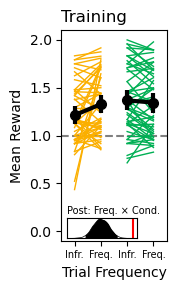

In [13]:
plot_by_condition_and_categorical(
    training_df,
    'freq',
    'reward',
    title = 'Training',
    x_label = 'Trial Frequency',
    y_label = 'Mean Reward',
    x_tick_labels = ['Infr.', 'Freq.'], 
    y_lim = [-.1, 2.1],
    summary_fname = f'{FIG_PATH}/stats/training-reward-by-frequency.pkl',
    fname = f'{FIG_PATH}/training-reward-by-frequency.pdf',
    posterior = fitted_preg2.posterior['freq:sem_congruent'],
    posterior_config = {
        'label': 'Post: Freq. × Cond.',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48),
)

## Average test (old) reward by frequency and condition

In [14]:
model_df = test_df.loc[test_df['old'], ['id', 'sem_congruent', 'freq', 'reward']]
model_df = model_df.reset_index(drop=True)

model_preg3 = bmb.Model(
    "reward ~ freq*sem_congruent + (1|id)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg3 = model_preg3.fit(
    random_seed = 3
)
az.summary(fitted_preg3)[-5:]

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.214,0.069,1.083,1.347,0.001,0.001,2479.0,3017.0,1.0
freq,0.098,0.067,-0.035,0.227,0.001,0.001,3571.0,3052.0,1.0
freq:sem_congruent,-0.191,0.096,-0.366,-0.001,0.002,0.001,3188.0,2687.0,1.0
sem_congruent,0.200,0.097,0.011,0.388,0.002,0.002,1962.0,2446.0,1.0
sigma,0.657,0.018,0.621,0.693,0.000,0.000,3076.0,2891.0,1.0


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/3825722027.py:576: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


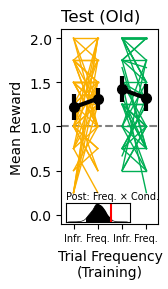

In [15]:
plot_by_condition_and_categorical(
    test_df.loc[test_df['old']],
    'freq',
    'reward',
    title = 'Test (Old)',
    x_label = 'Trial Frequency\n(Training)',
    y_label = 'Mean Reward',
    x_tick_labels = ['Infr.', 'Freq.'], 
    y_lim = [-.1, 2.1],
    summary_fname = f'{FIG_PATH}/stats/test-old-reward-by-frequency.pkl',
    fname = f'{FIG_PATH}/test-old-reward-by-frequency.pdf',
    posterior = fitted_preg3.posterior['freq:sem_congruent'],
    posterior_config = {
        'label': 'Post: Freq. × Cond.',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48),
)

## Test performance by condition and target/options novelty

### Preregistered analysis 

In [44]:
idx = test_df['n_transitions_to_target'] != 0
model_df = test_df.loc[idx, [
    'id',
    'sem_congruent',
    'novel_target',
    'novel_options',
    'reward'
]]
model_df = model_df.reset_index(drop=True)

model_preg4 = bmb.Model(
    "reward ~ novel_target*sem_congruent + novel_options*sem_congruent + (1|id)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg4 = model_preg4.fit(
    random_seed = 4
)
az.summary(fitted_preg4)[-7:]

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.750,0.033,0.685,0.814,0.001,0.001,560.0,1313.0,1.0
novel_options,-0.002,0.016,-0.031,0.031,0.000,0.000,3690.0,3350.0,1.0
novel_options:sem_congruent,0.010,0.023,-0.037,0.052,0.000,0.000,3497.0,3553.0,1.0
novel_target,-0.010,0.016,-0.041,0.021,0.000,0.000,3083.0,3217.0,1.0
novel_target:sem_congruent,0.017,0.023,-0.026,0.061,0.000,0.000,3216.0,2657.0,1.0
sem_congruent,0.045,0.046,-0.049,0.130,0.002,0.001,555.0,1005.0,1.0
sigma,0.568,0.004,0.561,0.575,0.000,0.000,6929.0,2903.0,1.0


### Deviation analysis

In [42]:
idx = test_df['n_transitions_to_target'] == 1
model_df = test_df.loc[idx, [
    'id',
    'sem_congruent',
    'novel_target',
    'novel_options',
    'reward'
]]
model_df = model_df.reset_index(drop=True)

model_preg4_dev = bmb.Model(
    "reward ~ novel_target*sem_congruent + novel_options*sem_congruent + (1|id)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg4_dev = model_preg4_dev.fit(
    random_seed = 4
)
az.summary(fitted_preg4_dev)[-7:]

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.628,0.030,0.569,0.686,0.001,0.001,725.0,1650.0,1.0
novel_options,-0.009,0.016,-0.039,0.023,0.000,0.000,2589.0,2953.0,1.0
novel_options:sem_congruent,0.025,0.022,-0.019,0.069,0.000,0.000,2596.0,2953.0,1.0
novel_target,-0.015,0.016,-0.044,0.016,0.000,0.000,2705.0,3168.0,1.0
novel_target:sem_congruent,0.033,0.023,-0.011,0.078,0.000,0.000,2555.0,2825.0,1.0
sem_congruent,0.015,0.042,-0.069,0.095,0.002,0.001,767.0,1697.0,1.0
sigma,0.452,0.003,0.445,0.458,0.000,0.000,5768.0,2857.0,1.0


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1179783681.py:698: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


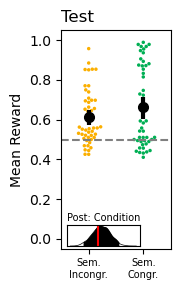

In [131]:
plot_by_categorical(
    test_df.loc[test_df['n_transitions_to_target'] == 1],
    'sem_congruent',
    'reward',
    title = 'Test',
    x_label = None,
    y_label = 'Mean Reward',
    x_tick_labels = ['Sem.\nIncongr.', 'Sem.\nCongr.'], 
    y_lim = [-.05, 1.05],
    chance = .5,
    summary_fname = f'{FIG_PATH}/stats/test-reward-by-condition.pkl',
    fname = f'{FIG_PATH}/test-reward-by-condition.pdf',
    posterior = fitted_preg4_dev.posterior['sem_congruent'],
    posterior_config = {
        'label': 'Post: Condition',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48),
    palette = CONDITION_COLORS
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1535960342.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


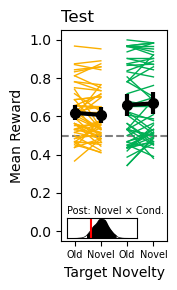

In [77]:
plot_by_condition_and_categorical(
    test_df.loc[test_df['n_transitions_to_target'] == 1],
    'novel_target',
    'reward',
    title = 'Test',
    x_label = 'Target Novelty',
    y_label = 'Mean Reward',
    x_tick_labels = ['Old', 'Novel'], 
    y_lim = [-.05, 1.05],
    chance = .5,
    summary_fname = f'{FIG_PATH}/stats/test-reward-by-novel-target.pkl',
    fname = f'{FIG_PATH}/test-reward-by-novel-target.pdf',
    posterior = fitted_preg4_dev.posterior['novel_target:sem_congruent'],
    posterior_config = {
        'label': 'Post: Novel × Cond.',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48)
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1535960342.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


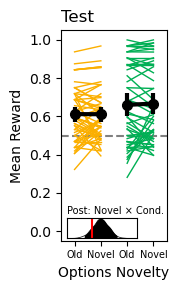

In [65]:
plot_by_condition_and_categorical(
    test_df.loc[test_df['n_transitions_to_target'] == 1],
    'novel_options',
    'reward',
    title = 'Test',
    x_label = 'Options Novelty',
    y_label = 'Mean Reward',
    x_tick_labels = ['Old', 'Novel'], 
    y_lim = [-.05, 1.05],
    chance = .5,
    summary_fname = f'{FIG_PATH}/stats/test-reward-by-novel-options.pkl',
    fname = f'{FIG_PATH}/test-reward-by-novel-options.pdf',
    posterior = fitted_preg4_dev.posterior['novel_options:sem_congruent'],
    posterior_config = {
        'label': 'Post: Novel × Cond.',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48)
)

## Composition spurious predictiveness by condition

In [125]:
idx = test_df['spurious_trial'] == 1
model_df = test_df.loc[idx, ['id', 'sem_congruent', 'comp_spur_pred']]
model_preg7 = bmb.Model(
    'comp_spur_pred ~ sem_congruent + (1|id)',
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg7 = model_preg7.fit(
    random_seed = 7,
    tune = 1000,
    draws = 1000
)
az.summary(fitted_preg7)[-3:]

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.094,0.043,1.009,1.176,0.001,0.001,2690.0,2717.0,1.0
sem_congruent,-0.079,0.061,-0.201,0.033,0.001,0.001,2658.0,3150.0,1.0
sigma,0.685,0.018,0.651,0.723,0.000,0.000,2765.0,2928.0,1.0


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1179783681.py:698: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


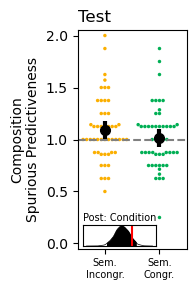

In [132]:
plot_by_categorical(
    model_df,
    'sem_congruent',
    'comp_spur_pred',
    title = 'Test',
    x_label = None,
    y_label = 'Composition\nSpurious Predictiveness',
    x_tick_labels = ['Sem.\nIncongr.', 'Sem.\nCongr.'], 
    y_lim = [-.05, 2.05],
    chance = 1,
    summary_fname = f'{FIG_PATH}/stats/comp-spur-pred-by-condition.pkl',
    fname = f'{FIG_PATH}/comp-spur-pred-by-condition.pdf',
    posterior = fitted_preg7.posterior['sem_congruent'],
    posterior_config = {
        'label': 'Post: Condition',
        'label_loc': 'left'
    },
    bbox_to_anchor = (-.17, -.34, .95, 0.48),
    palette = CONDITION_COLORS
)

# Model Fits


## Plot group AICs

In [133]:
plot_df = model_fits_df[['model_label', 'aic']]
plot_df = plot_df.groupby(['model_label'])
plot_df = plot_df.sum()
plot_df

,aic
model_label,
ff,52710.355247
null,58551.528636
ss,56736.734722
ss-sampler,53837.624487


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/4018160201.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Semantic\nInongruent', 'Semantic\nCongruent'])


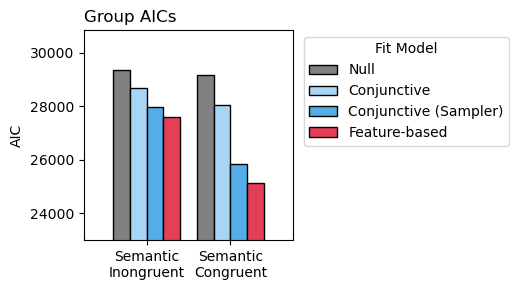

In [134]:

plot_df = model_fits_df[['sem_congruent', 'model_label', 'aic']]
plot_df = plot_df.groupby(['sem_congruent', 'model_label'])
plot_df = plot_df.sum()
plot_df = plot_df.reset_index()

fig, ax = plt.subplots(figsize=(4.5, 3))
sns.barplot(
    data = plot_df,
    x = 'sem_congruent',
    y = 'aic',
    hue = 'model_label',
    hue_order = MODEL_COLORS.keys(),
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    MODEL_LABELS,
    title = 'Fit Model',
    loc = (1.05, .45)
)
ax.set_xlabel(None)
ax.set_xticklabels(['Semantic\nInongruent', 'Semantic\nCongruent'])
ax.set_ylabel('AIC')
ax.set_ylim(23000, None)
ax.set_xlim(-0.75, 1.75)
ax.set_title('Group AICs', loc='left') 
set_axis_ratio(ax)
fig.tight_layout()
plt.savefig(f'{FIG_PATH}/group-aic.pdf')

## Plot fits by subject-level AIC comparisons

In [135]:
plot_df = best_fits[['model_label', 'best_fit']]
plot_df = plot_df.groupby(['model_label'])
plot_df = plot_df.sum()
plot_df['best_fit'] = plot_df['best_fit']/np.sum(plot_df['best_fit'])
plot_df

,best_fit
model_label,
ff,0.46
null,0.24
ss,0.09
ss-sampler,0.21


/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1987193125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/1987193125.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_LABELS, rotation=45, ha='right')


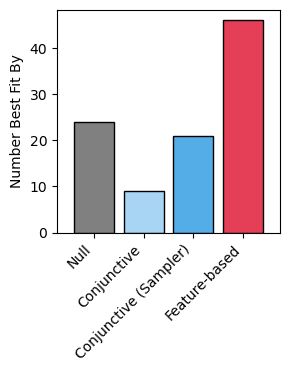

In [136]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.countplot(
    data = best_fits,
    x = 'model_label',
    palette = MODEL_COLORS,
    order = MODEL_COLORS.keys(),
    edgecolor = 'black'
)
ax.set_xlim(-.75, 3.75)
ax.set_ylabel('Number Best Fit By')
ax.set_xlabel(None)
ax.set_xticklabels(MODEL_LABELS, rotation=45, ha='right')
set_axis_ratio(ax)
fig.tight_layout()
plt.savefig(f'{FIG_PATH}/fit-counts.pdf')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_10041/2565719311.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_LABELS, rotation=45, ha='right')


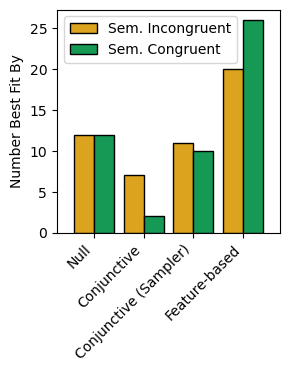

In [137]:
fig, ax = plt.subplots(figsize=(3, 4))
best_fits['sem_congruent'] = best_fits['sem_congruent'].astype(str)
sns.countplot(
    data = best_fits,
    x = 'model_label',
    hue = 'sem_congruent',
    palette = CONDITION_COLORS,
    order = MODEL_COLORS.keys(),
    edgecolor = 'black'
)
ax.legend(['Sem. Incongruent', 'Sem. Congruent'], loc='upper left')
ax.set_xlim(-.75, 3.75)
ax.set_ylabel('Number Best Fit By')
ax.set_xlabel(None)
ax.set_xticklabels(MODEL_LABELS, rotation=45, ha='right')
set_axis_ratio(ax)
fig.tight_layout()
plt.savefig(f'{FIG_PATH}/fit-counts-by-condition.pdf')

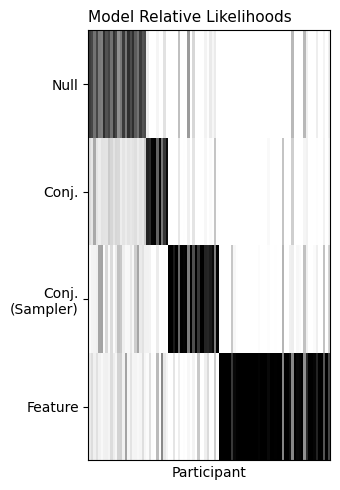

In [19]:
aics = model_fits_df[['id', 'model_label', 'aic']]
aics = pd.pivot(
    aics,
    index = 'id',
    columns = 'model_label',
    values = 'aic'
)
aics = aics.reset_index()

# Re-order columns
aics = aics[['id', 'null', 'ss', 'ss-sampler', 'ff']]

# Compute model relative likelihoods from raw AICs
raw_aics = np.array(aics.iloc[:, 1:])
delta_aic = raw_aics - np.min(raw_aics, axis=1).reshape(-1, 1)
numerator = np.exp(-delta_aic/2)
aic_w = numerator/np.sum(numerator, axis=1).reshape(-1, 1)

# Sort the rows based on the maximum value index
max_indices = np.argmax(aic_w, axis=1)
sorted_indices = np.argsort(max_indices)
aic_w = aic_w[sorted_indices]
aic_w = aic_w.T

# Covert to data frame
relative_likelihoods = pd.DataFrame(
    aic_w.T,
    columns = aics.columns[1:]
)
relative_likelihoods
relative_likelihoods['id'] = np.array(aics['id'])[sorted_indices]

# Create the heatmap with alpha values based on cell value
fig, ax = plt.subplots(figsize=(3.5, 5))
for i, model_label in enumerate(aics.columns[1:]):
    for j in range(aic_w.shape[1]):
        ax.add_patch(
            plt.Rectangle(
                (j, 3 - i), 1, 1,
                color = 'k',#MODEL_COLORS[model_label],
                alpha = aic_w[i, j],
                linewidth = 0
                )
            )

# Remove axes and ticks for clarity
ax.set_xticks([])
ax.set_yticks([.5, 1.5, 2.5, 3.5], labels=MODEL_LABELS[::-1])
ax.set_yticklabels([
    'Feature',
    'Conj.\n(Sampler)',
    'Conj.',
    'Null'
])
ax.set_xlim(0, aic_w.shape[1])
ax.set_ylim(0, aic_w.shape[0])
ax.set_xlabel('Participant')
ax.set_title('Model Relative Likelihoods', loc='left', fontsize=11)

fig.tight_layout()

plt.savefig(f'{FIG_PATH}/model-relative-likelihoods.pdf')


In [20]:
best_relative_likelihoods = pd.melt(
    relative_likelihoods,
    'id',
    value_name = 'rl'
)

best_relative_likelihoods = pd.merge(
    model_fits_df[['id', 'model_label', 'best_fit']], 
    best_relative_likelihoods
)
idx = best_relative_likelihoods['best_fit'] == 1
best_relative_likelihoods = best_relative_likelihoods.loc[idx]

best_relative_likelihoods = best_relative_likelihoods[['model_label', 'rl']].groupby('model_label')
mean_relative_likelihoods = np.round(best_relative_likelihoods.mean(), 4)
std_relative_likelihoods = np.round(best_relative_likelihoods.std(), 4)

print('Means')
print(mean_relative_likelihoods)

print('\n\nSDs')
print(std_relative_likelihoods)

Means
                 rl
model_label        
ff           0.9355
null         0.6691
ss           0.8406
ss-sampler   0.8813


SDs
                 rl
model_label        
ff           0.1469
null         0.1173
ss           0.1690
ss-sampler   0.1679


### Summarize parameter fits

#### Means

In [141]:
param_fits = best_fits[[
    'model_label',
    'alpha',
    'beta',
    'segmentation',
    'sampler_feature_weight',
    'sampler_specificity'
]]

def sigmoid(x):
    """
    Sigmoid function

    Arguments
    ---------
    x : int or float
        input value

    Returns
    -------
    float
        sigmoid of x
    """
    return 1 / (1 + np.exp(-x))
    
param_fits['beta_trans'] = sigmoid(param_fits['beta'])
param_fits['sampler_specificity_trans'] = sigmoid(param_fits['sampler_specificity'] - 1)
param_fits = param_fits.groupby('model_label')
param_fits = param_fits.mean()
param_fits = np.round(param_fits, 4)
param_fits

,alpha,beta,segmentation,sampler_feature_weight,sampler_specificity,beta_trans,sampler_specificity_trans
model_label,,,,,,,
ff,0.7631,976.8027,0.6652,1.0000,1.0000,0.6154,0.5000
null,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.2689,0.1192
ss,0.9999,0.1326,0.0000,1.0000,1.0000,0.5331,0.5000
ss-sampler,0.4204,600.5052,0.0000,0.4371,26.4971,0.9224,0.7320


#### Standard Deviations

In [142]:
param_fits = best_fits[[
    'model_label',
    'alpha',
    'beta',
    'segmentation',
    'sampler_feature_weight',
    'sampler_specificity'
]]
param_fits['beta_trans'] = sigmoid(param_fits['beta'])
param_fits['sampler_specificity_trans'] = sigmoid(param_fits['sampler_specificity'] - 1)
param_fits = param_fits.groupby('model_label')
param_fits = param_fits.std()
param_fits = np.round(param_fits, 4)
param_fits

,alpha,beta,segmentation,sampler_feature_weight,sampler_specificity,beta_trans,sampler_specificity_trans
model_label,,,,,,,
ff,0.3526,6617.0220,0.3971,0.0000,0.0000,0.1537,0.0000
null,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ss,0.0000,0.0450,0.0000,0.0000,0.0000,0.0112,0.0000
ss-sampler,0.4590,2145.4187,0.0000,0.3336,69.5762,0.1649,0.2191


### Preregistered analysis 5 - Are participants' choices in each condition best explained by the feature-based model?

#### All participants irrespective of condition

In [87]:
model_preg5 = bmb.Model(
    'ff_fit ~ 1',
    best_fits,
    family = 'bernoulli',
    link = 'logit'
)
fitted_preg5 = model_preg5.fit(
    random_seed = 5
)
az.summary(fitted_preg5)

Modeling the probability that ff_fit==1


Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.158,0.193,-0.541,0.214,0.005,0.003,1787.0,2786.0,1.0


#### Semantic incongruent condition

In [88]:
idx = best_fits['sem_congruent'] == 0
model_preg5a = bmb.Model(
    'ff_fit ~ 1',
    best_fits.loc[idx],
    family = 'bernoulli',
    link = 'logit'
)
fitted_preg5a = model_preg5a.fit(
    random_seed = 51
)
az.summary(fitted_preg5a)

Modeling the probability that ff_fit==1


Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.389,0.285,-0.957,0.156,0.007,0.005,1630.0,2639.0,1.0


#### Semantic congruent condition

In [89]:
idx = best_fits['sem_congruent'] == 1
model_preg5b = bmb.Model(
    'ff_fit ~ 1',
    best_fits.loc[idx],
    family = 'bernoulli',
    link = 'logit'
)
fitted_preg5b = model_preg5b.fit(
    random_seed = 52
)
az.summary(fitted_preg5b)

Modeling the probability that ff_fit==1


Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.078,0.284,-0.477,0.63,0.007,0.005,1640.0,2387.0,1.0


### Deviation - treating all models equally rather than comparing feature-based to any non-feature-based (including null)

#### All participants irrespective of condition

In [26]:
model_preg5_dev = bmb.Model(
    "model_label ~ 1",
    best_fits,
    family = 'categorical'
)
fitted_preg5_dev = model_preg5_dev.fit(
    random_seed = 513
)
az.summary(fitted_preg5_dev)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[null],-0.640,0.254,-1.174,-0.176,0.004,0.003,3981.0,3301.0,1.0
Intercept[ss],-1.629,0.362,-2.314,-0.916,0.006,0.004,3800.0,2791.0,1.0
Intercept[ss-sampler],-0.778,0.262,-1.310,-0.268,0.004,0.003,3737.0,2751.0,1.0


#### Semantic incongruent condition

In [24]:
idx = best_fits['sem_congruent'] == 0
model_preg5a_dev = bmb.Model(
    "model_label ~ 1",
    best_fits.loc[idx],
    family = 'categorical'
)
fitted_preg5a_dev = model_preg5a_dev.fit(
    random_seed = 511
)
az.summary(fitted_preg5a_dev)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[null],-0.496,0.367,-1.187,0.239,0.007,0.005,3113.0,3266.0,1.0
Intercept[ss],-1.051,0.445,-1.997,-0.228,0.008,0.006,3243.0,2821.0,1.0
Intercept[ss-sampler],-0.582,0.381,-1.366,0.119,0.007,0.005,3109.0,2916.0,1.0


#### Semantic congruent condition

In [25]:
idx = best_fits['sem_congruent'] == 1
model_preg5b_dev = bmb.Model(
    "model_label ~ 1",
    best_fits.loc[idx],
    family = 'categorical'
)
fitted_preg5b_dev = model_preg5b_dev.fit(
    random_seed = 512
)
az.summary(fitted_preg5b_dev)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[null],-0.752,0.349,-1.392,-0.012,0.006,0.004,3875.0,2902.0,1.0
Intercept[ss],-2.547,0.711,-4.021,-1.295,0.013,0.011,3045.0,2206.0,1.0
Intercept[ss-sampler],-0.941,0.373,-1.673,-0.194,0.006,0.004,3946.0,3014.0,1.0


## Segmentation fits 

### Preregistered Analysis 6 - Is fit segmentation higher in the within-feature transitions condition?

In [28]:
idx = best_fits['model_label'] == 'ff'
model_df = best_fits.loc[idx]

idx = model_df['segmentation'] == 1
model_df.loc[idx, 'segmentation'] = .9999
idx = model_df['segmentation'] == 0
model_df.loc[idx, 'segmentation'] = .0001

model_preg6= bmb.Model(
    "segmentation ~ sem_congruent",
    model_df,
    family = 'beta',
    link = 'logit'
)
fitted_preg6 = model_preg6.fit(
    random_seed = 61
)
az.summary(fitted_preg6)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.461,0.304,-0.138,1.051,0.004,0.003,5059.0,3279.0,1.0
kappa,0.400,0.061,0.286,0.520,0.001,0.001,4681.0,3131.0,1.0
sem_congruent,-0.106,0.405,-0.880,0.676,0.005,0.006,5591.0,3209.0,1.0


### Get mean and HDI of posterior predictions

In [29]:
# Generate means and HDIs of each data group
posterior_summaries = []
for condition in [0, 1]:
    idx = model_df['sem_congruent'] == condition
    model = bmb.Model('segmentation ~ 1', model_df.loc[idx])
    fitted = model.fit(random_seed=23232)
    post_values = az.summary(fitted)
    post_values = post_values[['mean', 'hdi_2.5%', 'hdi_97.5%']].values[0]
    posterior_summaries.append(post_values)
posterior_summaries = np.array(posterior_summaries)

Output()

Output()

### Plot fit segmentation by condition

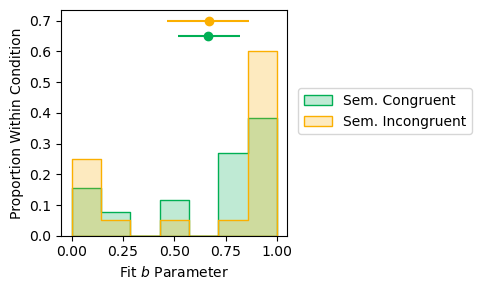

In [30]:
fig, ax = plt.subplots(figsize=(5, 3))

# Histogram of bias parameter fits
sns.histplot(
    data = model_df,
    x = 'segmentation',
    hue = 'sem_congruent',
    palette = CONDITION_COLORS,
    stat = 'probability',
    common_norm = False,
    element = 'step',
    ax = ax
)

# Plot means and 95% HDIs
ax.hlines(.7, *posterior_summaries[0, 1:], color=CONDITION_COLORS[0])
ax.plot(posterior_summaries[0, 0], .7, 'o', color=CONDITION_COLORS[0])
ax.hlines(.65, *posterior_summaries[1, 1:], color=CONDITION_COLORS[1])
ax.plot(posterior_summaries[1, 0], .65, 'o', color=CONDITION_COLORS[1])

# Format
ax.legend(['Sem. Congruent', 'Sem. Incongruent'], loc=(1.05, .45))
ax.set_xlabel('Fit Bias Parameter')
ax.set_xlabel(r'Fit $\it{b}$ Parameter')
ax.set_ylabel('Proportion Within Condition')
set_axis_ratio(ax)
fig.tight_layout()

plt.savefig(f'{FIG_PATH}/causal-bias-by-condition.pdf')

# Training Transition Influence Analysis

### Preregistered Analysis 1: Are participants in the semantic congruent condition relatively more influenced by causal compared to spurious transitions?

In [50]:
model_preg1 = bmb.Model(
    "coef ~ sem_congruent*transition",
    mean_trans_influence_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1 = model_preg1.fit(
    random_seed = 1
)
az.summary(fitted_preg1)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.621,0.300,0.037,1.215,0.006,0.004,2779.0,2901.0,1.0
sem_congruent,-0.178,0.415,-0.982,0.618,0.008,0.006,2798.0,2600.0,1.0
sem_congruent:transition[causal],0.900,0.590,-0.292,2.036,0.012,0.009,2563.0,2573.0,1.0
sigma,2.078,0.105,1.872,2.280,0.002,0.001,3998.0,2923.0,1.0
transition[causal],1.122,0.424,0.292,1.914,0.008,0.006,2806.0,2954.0,1.0


#### Deviation: include a random intercept per logit comparison rather than averaging over logit coefficients

In [51]:
model_preg1_e1 = bmb.Model(
    "coef ~ sem_congruent*transition + (1|action)",
    trans_influence_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e1 = model_preg1_e1.fit(
    random_seed = 1,
    tune = 4000,
    draws = 2000,
    target_accept = .95
)
az.summary(fitted_preg1_e1)

Output()

There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.003,0.282,-0.709,0.603,0.036,0.033,193.0,38.0,1.02
1|action[2],0.015,0.279,-0.684,0.619,0.036,0.034,197.0,39.0,1.02
1|action[3],0.075,0.290,-0.640,0.690,0.038,0.036,209.0,39.0,1.02
1|action_sigma,0.343,0.503,0.000,1.546,0.069,0.054,218.0,40.0,1.02
Intercept,0.574,0.340,-0.104,1.341,0.041,0.029,201.0,36.0,1.02
sem_congruent,-0.154,0.247,-0.626,0.338,0.005,0.003,2817.0,5207.0,1.00
sem_congruent:transition[causal],0.875,0.352,0.173,1.563,0.006,0.005,2927.0,4551.0,1.00
sigma,2.195,0.065,2.073,2.321,0.002,0.001,956.0,3129.0,1.00
transition[causal],1.139,0.250,0.649,1.615,0.006,0.004,1983.0,4634.0,1.00


### Get posterior predictions from model

In [52]:
# Predict transition influence from posterior
posterior = np.array([
    np.array(fitted_preg1_e1.posterior['Intercept']).flatten(),
    np.array(fitted_preg1_e1.posterior['sem_congruent']).flatten(),
    np.array(fitted_preg1_e1.posterior['transition']).flatten(),
    np.array(fitted_preg1_e1.posterior['sem_congruent:transition']).flatten()
])
pred_X = np.array([
    [1, 1, 0, 1*0],
    [1, 1, 1, 1*1],
    [1, 0, 0, 0*0],
    [1, 0, 1, 0*1]
])
pred_y = pred_X@posterior

# Plot mean and 95% HDI of posterior prediction
pred_means = np.mean(pred_y, axis=1)
pred_hdis = az.hdi(pred_y.T)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/4204881730.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdis = az.hdi(pred_y.T)


In [53]:
# Generate means and HDIs of each data group
posterior_summaries = []
for condition in [0, 1]:
    for transition in ['spurious', 'causal']:
        idx = (
            (mean_trans_influence_df['sem_congruent'] == condition) &
            (mean_trans_influence_df['transition'] == transition)
        )
        model = bmb.Model('coef ~ 1', mean_trans_influence_df.loc[idx])
        fitted = model.fit(random_seed=4793)
        post_values = az.summary(fitted)
        post_values = post_values[['mean', 'hdi_2.5%', 'hdi_97.5%']].values[0]
        posterior_summaries.append(post_values)
posterior_summaries = np.array(posterior_summaries)

Output()

Output()

Output()

Output()

### Plot transition influence by condition 

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/508130528.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


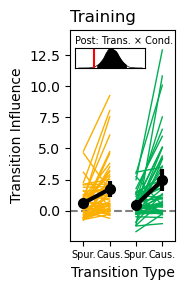

In [69]:
# Each participants average reward on old and novel target trials
plot_df = mean_trans_influence_df[['id', 'sem_congruent', 'transition', 'coef']]
plot_df['transition'] = plot_df['transition'].map({
    'spurious': 0,
    'causal': 1
}).astype(int)
plot_df['group'] = plot_df['sem_congruent']*2 + plot_df['transition']

fig, ax = plt.subplots(figsize=(2, 3))

# Plot data
ax.axhline(0, c='.5', linestyle='--')
sns.lineplot(
    data = plot_df,
    x = 'group',
    y = 'coef',
    hue = 'id',
    palette = condition_id_palette,
    linewidth = 1,
    ax = ax
)

for i, hdi in enumerate(posterior_summaries[:, 1:]):
    ax.vlines(np.unique(plot_df['group'])[i], *hdi, color='black', linewidth=3)
ax.plot(
    np.unique(plot_df['group'])[:2],
    posterior_summaries[:2, 0],
    '-ok',
    linewidth = 3,
    markersize = 7
)
ax.plot(
    np.unique(plot_df['group'])[2:],
    posterior_summaries[2:, 0],
    '-ok',
    linewidth = 3,
    markersize = 7
)

# Format
ax.set_xlim([np.min(np.unique(plot_df['group'])) - .5, np.max(np.unique(plot_df['group'])) + .5])
ax.get_legend().remove()
ax.set_xticks(np.unique(plot_df['group']))
ax.set_xticklabels(['Spur.', 'Caus.']*2, fontsize=7)

ax.set_xlabel('Transition Type')
ax.set_ylabel('Transition Influence')
ax.set_ylim([None, 14.5])
ax.set_title('Training', loc='left')
set_axis_ratio(ax, 2)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '70%',
    height = '20%',
    bbox_to_anchor =  (-.17, 0.47, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg1_e1.posterior['sem_congruent:transition'].values.flatten(),
    label = 'Post: Trans. × Cond.',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/transition-influence-by-condition.pdf')

### Run pairwise comparisons models

#### Comparing transition type within within-feature transitions condition

In [27]:
idx = trans_influence_df['sem_congruent'] == 0
model_preg1_e2a = bmb.Model(
    "coef ~ transition + (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2a = model_preg1_e2a.fit(
    random_seed = 121, 
    target_accept = .9,
    tune = 4000,
    draws = 4000
)
az.summary(fitted_preg1_e2a)

Output()

There were 411 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.105,0.369,-1.309,0.451,0.046,0.042,155.0,35.0,1.03
1|action[2],-0.051,0.366,-1.128,0.631,0.045,0.040,156.0,39.0,1.03
1|action[3],0.025,0.364,-0.858,0.923,0.044,0.038,157.0,37.0,1.03
1|action_sigma,0.423,0.534,0.000,1.690,0.060,0.045,178.0,96.0,1.03
Intercept,1.785,0.382,0.853,2.668,0.046,0.038,155.0,38.0,1.03
sigma,1.959,0.080,1.801,2.115,0.002,0.001,1966.0,2698.0,1.00
transition[spurious],-1.133,0.224,-1.578,-0.702,0.003,0.002,5514.0,3530.0,1.01


#### Comparing transition type within between-feature transitions condition

In [28]:
idx = trans_influence_df['sem_congruent'] == 1
model_preg1_e2b = bmb.Model(
    "coef ~ transition + (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2b = model_preg1_e2b.fit(
    random_seed = 122,
    target_accept = .9,
    tune = 4000,
    draws = 4000
)
az.summary(fitted_preg1_e2b)

Output()

There were 1750 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],0.226,0.726,-0.547,2.206,0.305,0.243,13.0,214.0,1.22
1|action[2],0.244,0.794,-0.467,2.471,0.337,0.264,13.0,1053.0,1.21
1|action[3],0.269,0.755,-0.404,2.353,0.319,0.252,13.0,1050.0,1.22
1|action_sigma,0.724,0.993,0.006,2.756,0.335,0.245,18.0,93.0,1.16
Intercept,2.207,0.772,0.123,2.944,0.327,0.244,13.0,6.0,1.21
sigma,2.425,0.093,2.236,2.612,0.001,0.001,4061.0,7505.0,1.12
transition[spurious],-1.957,0.307,-2.556,-1.438,0.069,0.050,23.0,234.0,1.11


#### Comparing condition within spurious transitions 

In [29]:
idx = trans_influence_df['transition'] == 'spurious'
model_preg1_e2c = bmb.Model(
    "coef ~ sem_congruent + (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2c = model_preg1_e2c.fit(
    random_seed = 123,
    target_accept = .9,
    tune = 4000,
    draws = 4000
)
az.summary(fitted_preg1_e2c)

Output()

There were 734 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],0.019,0.365,-1.142,0.607,0.062,0.057,66.0,24.0,1.05
1|action[2],-0.074,0.368,-1.272,0.484,0.062,0.055,70.0,24.0,1.05
1|action[3],0.021,0.367,-1.146,0.598,0.062,0.056,69.0,25.0,1.04
1|action_sigma,0.328,0.384,0.000,1.176,0.041,0.029,122.0,234.0,1.03
Intercept,0.619,0.383,0.044,1.786,0.067,0.054,64.0,22.0,1.04
sem_congruent,-0.155,0.172,-0.487,0.173,0.008,0.006,486.0,1370.0,1.01
sigma,1.454,0.058,1.335,1.564,0.001,0.001,5505.0,8343.0,1.01


#### Comparing condition within causal transitions 

In [30]:
idx = trans_influence_df['transition'] == 'causal'
model_preg1_e2d = bmb.Model(
    "coef ~ sem_congruent + (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2d = model_preg1_e2d.fit(
    random_seed = 123,
    target_accept = .9,
    tune = 4000,
    draws = 4000
)
az.summary(fitted_preg1_e2d)

Output()

There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.123,0.441,-1.358,0.716,0.032,0.029,355.0,124.0,1.01
1|action[2],0.001,0.432,-1.026,1.098,0.030,0.024,368.0,126.0,1.01
1|action[3],0.032,0.428,-1.115,0.948,0.029,0.023,395.0,140.0,1.01
1|action_sigma,0.542,0.660,0.000,1.948,0.035,0.025,690.0,361.0,1.01
Intercept,1.774,0.453,0.815,2.915,0.032,0.026,350.0,119.0,1.01
sem_congruent,0.717,0.317,0.120,1.368,0.005,0.003,4732.0,4102.0,1.00
sigma,2.747,0.121,2.509,2.996,0.007,0.005,434.0,140.0,1.01


### Compare to chance

In [31]:
idx = (
    (trans_influence_df['sem_congruent'] == 0) &
    (trans_influence_df['transition'] == 'spurious')
)
model_preg1_e2a = bmb.Model(
    "coef ~ (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2a = model_preg1_e2a.fit(
    random_seed = 121,
    target_accept = .9,
    tune = 3000,
    draws = 3000
)
az.summary(fitted_preg1_e2a)

Output()

There were 72 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.001,0.260,-0.561,0.593,0.013,0.013,939.0,389.0,1.01
1|action[2],-0.016,0.256,-0.611,0.493,0.012,0.012,931.0,388.0,1.00
1|action[3],0.052,0.260,-0.537,0.602,0.013,0.014,903.0,369.0,1.01
1|action_sigma,0.321,0.383,0.000,1.091,0.015,0.011,1194.0,725.0,1.00
Intercept,0.596,0.257,0.070,1.145,0.013,0.009,874.0,333.0,1.01
sigma,1.501,0.086,1.331,1.667,0.001,0.001,6646.0,5811.0,1.00


In [32]:
idx = (
    (trans_influence_df['sem_congruent'] == 0) &
    (trans_influence_df['transition'] == 'causal')
)
model_preg1_e2b = bmb.Model(
    "coef ~ (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2b = model_preg1_e2b.fit(
    random_seed = 122,
    target_accept = .9,
    tune = 3000,
    draws = 3000
)
az.summary(fitted_preg1_e2b)

Output()

There were 86 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.097,0.406,-0.994,0.785,0.014,0.011,1159.0,730.0,1.00
1|action[2],0.021,0.401,-0.931,0.851,0.015,0.012,1115.0,696.0,1.00
1|action[3],0.095,0.406,-0.761,1.050,0.014,0.012,1269.0,764.0,1.00
1|action_sigma,0.554,0.652,0.000,1.938,0.024,0.018,1272.0,891.0,1.01
Intercept,1.734,0.398,0.950,2.746,0.015,0.011,973.0,634.0,1.00
sigma,2.333,0.139,2.070,2.606,0.002,0.001,4897.0,5525.0,1.00


In [33]:
idx = (
    (trans_influence_df['sem_congruent'] == 1) &
    (trans_influence_df['transition'] == 'spurious')
)
model_preg1_e2c = bmb.Model(
    "coef ~ (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2c = model_preg1_e2c.fit(
    random_seed = 123,
    target_accept = .9,
    tune = 3000,
    draws = 3000
)
az.summary(fitted_preg1_e2c)

Output()

There were 132 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],0.062,0.302,-0.568,0.816,0.015,0.012,633.0,227.0,1.01
1|action[2],-0.100,0.312,-0.852,0.580,0.017,0.015,570.0,254.0,1.01
1|action[3],0.006,0.295,-0.619,0.801,0.015,0.012,624.0,239.0,1.01
1|action_sigma,0.405,0.492,0.000,1.402,0.025,0.019,829.0,304.0,1.00
Intercept,0.458,0.297,-0.262,1.148,0.017,0.015,548.0,229.0,1.01
sigma,1.415,0.083,1.259,1.580,0.002,0.001,3171.0,2555.0,1.00


In [34]:
idx = (
    (trans_influence_df['sem_congruent'] == 1) &
    (trans_influence_df['transition'] == 'causal')
)
model_preg1_e2d = bmb.Model(
    "coef ~ (1|action)",
    trans_influence_df.loc[idx],
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e2d = model_preg1_e2d.fit(
    random_seed = 124,
    target_accept = .9,
    tune = 3000,
    draws = 3000
)
az.summary(fitted_preg1_e2d)

Output()

There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.011,0.638,-1.496,1.477,0.061,0.050,220.0,63.0,1.02
1|action[2],0.117,0.642,-1.111,1.874,0.060,0.053,241.0,69.0,1.02
1|action[3],0.089,0.635,-1.142,1.832,0.062,0.054,219.0,64.0,1.02
1|action_sigma,0.761,0.919,0.000,2.814,0.077,0.054,293.0,106.0,1.02
Intercept,2.394,0.639,0.457,3.549,0.065,0.046,209.0,53.0,1.02
sigma,3.131,0.179,2.804,3.499,0.003,0.002,4309.0,5659.0,1.00


## Does the difference between semantic congruent and incongruent change across training?

In [259]:
model_preg1_e3 = bmb.Model(
    'cumulative_coef ~ t*between_cond*transition + (1|action)',
    trans_influence_trial_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e3 = model_preg1_e3.fit(
    random_seed = 13,
    tune = 4000,
    draws = 2000,
    target_accept = .95
)
az.summary(fitted_preg1_e3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, t, between_cond, t:between_cond, transition, t:transition, between_cond:transition, t:between_cond:transition, 1|action_sigma, 1|action_offset]


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 214 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],0.747,2.361,-4.639,6.505,0.094,0.067,1158.0,391.0,1.0
1|action[2],-1.267,2.353,-6.947,4.209,0.094,0.091,1144.0,389.0,1.0
1|action[3],0.193,2.350,-5.037,6.037,0.096,0.080,1111.0,391.0,1.0
1|action_sigma,3.392,3.425,0.279,10.908,0.125,0.092,1207.0,613.0,1.0
Intercept,-0.330,2.443,-5.916,5.196,0.088,0.069,1211.0,389.0,1.0
between_cond,-1.716,1.081,-3.938,0.257,0.023,0.016,2236.0,3830.0,1.0
between_cond:transition[true],12.902,1.524,9.980,15.865,0.032,0.023,2276.0,3952.0,1.0
sigma,5.315,0.134,5.053,5.578,0.003,0.002,2948.0,1406.0,1.0
t,0.287,0.018,0.251,0.321,0.000,0.000,2176.0,3217.0,1.0
t:between_cond,0.262,0.025,0.213,0.312,0.001,0.000,2160.0,3650.0,1.0


In [71]:
# Get mean and 95% HDI timeseries
cumulative_transition_influence_summary = data_summary(
    trans_influence_trial_df,
    ['transition', 'sem_congruent', 't'],
    'cumulative_coef',
    seed = 3422,
    fname = f'{FIG_PATH}/stats/cumulative_transition_influence_summary.pkl'
)

# Reformat for plotting
stats_series = unpack_summary_timeseries(cumulative_transition_influence_summary)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

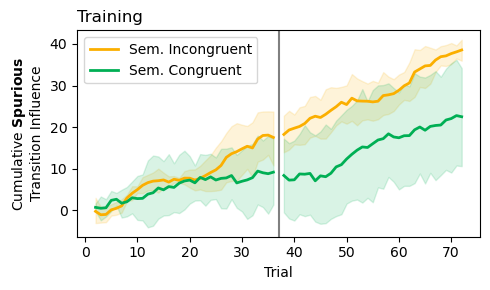

In [118]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.axvline(int(72/2) + 1, c='.5')

for condition in ['0', '1']:
    for block in [1, 2]:
        if block == 1:
            idx = stats_series['spurious', condition, 'x'] <= np.max(stats_series['spurious', condition, 'x'])/2
        else:
            idx = stats_series['spurious', condition, 'x'] > np.max(stats_series['spurious', condition, 'x'])/2
        ax.fill_between(
            stats_series['spurious', condition, 'x'][idx],
            stats_series['spurious', condition, 'hdi'][:, 0][idx],
            stats_series['spurious', condition, 'hdi'][:, 1][idx],
            color = CONDITION_COLORS[int(condition)],
            alpha = .15
        )
        ax.plot(
            stats_series['spurious', condition, 'x'][idx],
            stats_series['spurious', condition, 'mean'][idx],
            color = CONDITION_COLORS[int(condition)],
            label = condition,
            linewidth = 2
        )

handles = ax.get_legend_handles_labels()[0]
ax.set_title('Training', loc='left')
ax.legend(handles[1:-1], ['Sem. Incongruent', 'Sem. Congruent'])
ax.set_xlabel('Trial')
ax.set_ylabel(r'Cumulative $\bf{Spurious}$' + '\nTransition Influence')
fig.tight_layout()

plt.savefig(f'{FIG_PATH}/cumulative-spurious-transition-influence.pdf', dpi=300)

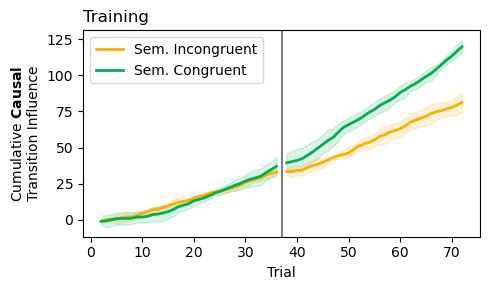

In [117]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.axvline(int(72/2) + 1, c='.5')

for condition in ['0', '1']:
    for block in [1, 2]:
        if block == 1:
            idx = stats_series['causal', condition, 'x'] <= np.max(stats_series['causal', condition, 'x'])/2
        else:
            idx = stats_series['causal', condition, 'x'] > np.max(stats_series['causal', condition, 'x'])/2
        ax.fill_between(
            stats_series['causal', condition, 'x'][idx],
            stats_series['causal', condition, 'hdi'][:, 0][idx],
            stats_series['causal', condition, 'hdi'][:, 1][idx],
            color = CONDITION_COLORS[int(condition)],
            alpha = .15
        )
        ax.plot(
            stats_series['causal', condition, 'x'][idx],
            stats_series['causal', condition, 'mean'][idx],
            color = CONDITION_COLORS[int(condition)],
            label = condition,
            linewidth = 2
        )

handles = ax.get_legend_handles_labels()[0]
ax.set_title('Training', loc='left')
ax.legend(handles[1:-1], ['Sem. Incongruent', 'Sem. Congruent'])
ax.set_xlabel('Trial')
ax.set_ylabel(r'Cumulative $\bf{Causal}$' + '\nTransition Influence')
fig.tight_layout()

plt.savefig(f'{FIG_PATH}/cumulative-causal-transition-influence.pdf', dpi=300)

## Relationship between transition influence and frequency sensitivity

### Training

In [111]:
model_df = trans_influence_df[['id', 'action', 'transition', 'coef']]
model_df = pd.pivot(
    data = model_df,
    index = ['id', 'action'],
    columns = 'transition',
    values = 'coef'
)
model_df = model_df.reset_index()
model_df = pd.merge(
    model_df,
    training_df[['id', 't', 'freq', 'reward']]
)

model_preg2_e2 = bmb.Model(
    "reward ~ freq*spurious*causal + (1|id) + (1|action)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg2_e2 = model_preg2_e2.fit(
    random_seed = 22,
    target_accept = .9,
    tune = 2000,
    draws = 2000
)

# Summary table
az.summary(fitted_preg2_e2)[-9:]

Output()

There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.167,0.030,1.110,1.229,0.001,0.001,989.0,1918.0,1.0
causal,0.067,0.008,0.051,0.083,0.000,0.000,1153.0,2565.0,1.0
freq,0.026,0.013,0.001,0.051,0.000,0.000,5101.0,5874.0,1.0
freq:causal,-0.001,0.004,-0.009,0.007,0.000,0.000,4153.0,4478.0,1.0
freq:spurious,0.068,0.009,0.050,0.087,0.000,0.000,3720.0,5567.0,1.0
freq:spurious:causal,-0.005,0.002,-0.008,-0.002,0.000,0.000,3040.0,4125.0,1.0
sigma,0.667,0.003,0.661,0.674,0.000,0.000,6906.0,4472.0,1.0
spurious,-0.039,0.009,-0.057,-0.020,0.000,0.000,2769.0,3992.0,1.0
spurious:causal,0.001,0.002,-0.002,0.004,0.000,0.000,2541.0,4031.0,1.0


In [112]:
# Summarize data
plot_df = model_df[['id', 'action', 'spurious', 'causal', 'freq', 'reward']]
plot_df = plot_df.groupby(['id', 'action', 'spurious', 'causal', 'freq'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()
plot_df = plot_df[['id', 'spurious', 'causal', 'freq', 'reward']]
plot_df = plot_df.groupby(['id', 'freq'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
posterior_summaries_spurious = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'spurious',
    seed = 2332,
    fname = f'{FIG_PATH}/stats/freq-by-spurious-influence.pkl'
)

# Get mean and 95% HDI for causal influence -> reward gain
posterior_summaries_causal = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'causal',
    seed = 4342,
    fname = f'{FIG_PATH}/stats/freq-by-causal-influence.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_80942/560446399.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


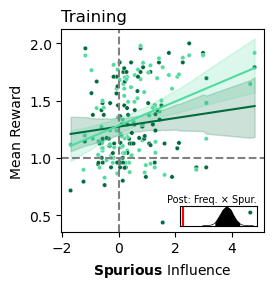

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'spurious',
    y = 'reward',
    hue = 'freq',
    palette = FREQUENCY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = posterior_summaries_spurious[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['freq'] == freq, 'spurious'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(r'$\bf{Spurious}$ Influence')
ax.set_ylabel('Mean Reward')
ax.get_legend().remove()
ax.set_title('Training', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.05, -.32, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg2_e2.posterior['freq:spurious'].values.flatten(),
    label = 'Post: Freq. × Spur.',
    label_loc = 'right',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/training-reward-by-spurious-influence.pdf')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/753490452.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


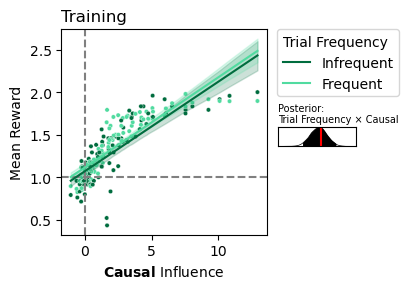

In [119]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'causal',
    y = 'reward',
    hue = 'freq',
    palette = FREQUENCY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = posterior_summaries_causal[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['freq'] == freq, 'causal'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(r'$\bf{Causal}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles[-2:],
    ['Infrequent', 'Frequent'],
    loc = (1.05, .675),
    title = 'Trial Frequency',
    alignment = 'left'
)
ax.set_title('Training', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .08, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg2_e2.posterior['freq:causal'].values.flatten(),
    label = 'Posterior:\nTrial Frequency × Causal',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/training-reward-by-causal-influence.pdf', bbox_inches='tight')

### Test

In [84]:
model_df = trans_influence_df[['id', 'action', 'transition', 'coef']]
model_df = pd.pivot(
    data = model_df,
    index = ['id', 'action'],
    columns = 'transition',
    values = 'coef'
)
model_df = model_df.reset_index()
model_df = pd.merge(
    model_df,
    test_df.loc[test_df['old'], ['id', 't', 'freq', 'reward']]
)

model_preg2_e3 = bmb.Model(
    "reward ~ freq*spurious*causal + (1|id) + (1|action)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg2_e3 = model_preg2_e3.fit(
    random_seed = 23,
    target_accept = .9,
    tune = 2000,
    draws = 2000
)

# Summary table
az.summary(fitted_preg2_e3)[-9:]

Output()

There were 402 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.133,0.061,0.990,1.241,0.007,0.005,111.0,22.0,1.04
causal,0.092,0.012,0.069,0.117,0.000,0.000,2072.0,4529.0,1.00
freq,-0.020,0.035,-0.084,0.051,0.001,0.001,852.0,2978.0,1.01
freq:causal,-0.006,0.011,-0.029,0.015,0.000,0.000,1348.0,3662.0,1.01
freq:spurious,0.093,0.024,0.043,0.139,0.000,0.000,5662.0,6027.0,1.01
freq:spurious:causal,-0.005,0.004,-0.014,0.003,0.000,0.000,3645.0,4482.0,1.00
sigma,0.628,0.009,0.610,0.646,0.000,0.000,5680.0,4198.0,1.01
spurious,-0.035,0.021,-0.075,0.008,0.000,0.000,4281.0,5142.0,1.01
spurious:causal,-0.001,0.003,-0.008,0.005,0.000,0.000,3866.0,4159.0,1.01


In [85]:
# Summarize data
plot_df = model_df[['id', 'action', 'spurious', 'causal', 'freq', 'reward']]
plot_df = plot_df.groupby(['id', 'action', 'spurious', 'causal', 'freq'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()
plot_df = plot_df[['id', 'spurious', 'causal', 'freq', 'reward']]
plot_df = plot_df.groupby(['id', 'freq'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
posterior_summaries_spurious = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'spurious',
    seed = 2190,
    fname = f'{FIG_PATH}/stats/test-freq-by-spurious-influence.pkl'
)

# Get mean and 95% HDI for causal influence -> reward gain
posterior_summaries_causal = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'causal',
    seed = 239823,
    fname = f'{FIG_PATH}/stats/test-freq-by-causal-influence.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/3286539193.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


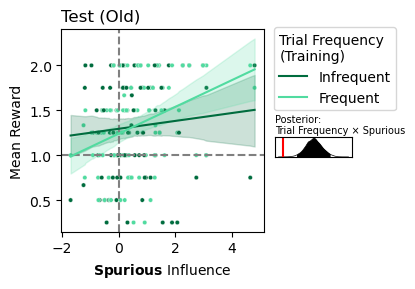

In [110]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'spurious',
    y = 'reward',
    hue = 'freq',
    palette = FREQUENCY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = posterior_summaries_spurious[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['freq'] == freq, 'spurious'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(r'$\bf{Spurious}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles[-2:],
    ['Infrequent', 'Frequent'],
    loc = (1.05, .6),
    title = 'Trial Frequency\n(Training)',
    alignment = 'left'
)
ax.set_title('Test (Old)', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .02, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg2_e3.posterior['freq:spurious'].values.flatten(),
    label = 'Posterior:\nTrial Frequency × Spurious',
    label_loc = 'left',
    chance_color = 'red'
)

plt.tight_layout()
plt.savefig(f'{FIG_PATH}/test-reward-by-spurious-influence.pdf', bbox_inches='tight')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/1113842993.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


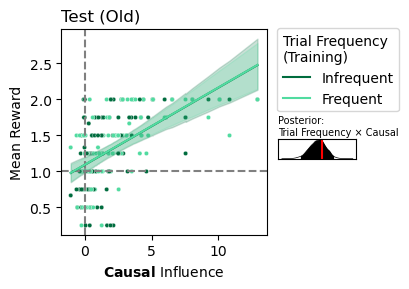

In [109]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'causal',
    y = 'reward',
    hue = 'freq',
    palette = FREQUENCY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = posterior_summaries_causal[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['freq'] == freq, 'causal'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(r'$\bf{Causal}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles[-2:],
    ['Infrequent', 'Frequent'],
    loc = (1.05, .6),
    title = 'Trial Frequency\n(Training)',
    alignment = 'left'
)
ax.set_title('Test (Old)', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .02, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg2_e3.posterior['freq:causal'].values.flatten(),
    label = 'Posterior:\nTrial Frequency × Causal',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-reward-by-causal-influence.pdf', bbox_inches='tight')

## Transition influence on generalization

In [83]:
model_df = trans_influence_df[['id', 'action', 'transition', 'coef']]
model_df = pd.pivot(
    data = model_df,
    index = ['id', 'action'],
    columns = 'transition',
    values = 'coef'
)
model_df = model_df.reset_index()
idx = test_df['n_transitions_to_target'] == 1
model_df = pd.merge(
    model_df,
    test_df.loc[idx, ['id', 't', 'novel_target', 'novel_options', 'reward']]
)

model_preg4_e1 = bmb.Model(
    "reward ~ novel_target*spurious*causal + novel_options*spurious*causal + (1|id) + (1|action)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg4_e1 = model_preg4_e1.fit(
    random_seed = 41,
    target_accept = .9,
    tune = 2000,
    draws = 2000
)

# Summary table
az.summary(fitted_preg4_e1)[-9:]

Output()

There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
novel_options:spurious,0.009,0.006,-0.003,0.021,0.0,0.0,2640.0,4544.0,1.0
novel_options:spurious:causal,-0.000,0.001,-0.002,0.002,0.0,0.0,2406.0,4309.0,1.0
novel_target,-0.003,0.009,-0.019,0.015,0.0,0.0,3246.0,3505.0,1.0
novel_target:causal,-0.000,0.003,-0.006,0.005,0.0,0.0,3002.0,4602.0,1.0
novel_target:spurious,0.010,0.006,-0.002,0.022,0.0,0.0,2528.0,4192.0,1.0
novel_target:spurious:causal,-0.001,0.001,-0.003,0.002,0.0,0.0,2286.0,3992.0,1.0
sigma,0.450,0.002,0.447,0.454,0.0,0.0,7849.0,5401.0,1.0
spurious,-0.011,0.008,-0.027,0.006,0.0,0.0,2069.0,3619.0,1.0
spurious:causal,-0.001,0.001,-0.003,0.002,0.0,0.0,1830.0,3171.0,1.0


In [73]:
# Summarize data
plot_df = model_df[[
    'id',
    'action',
    'spurious',
    'causal',
    'novel_target',
    'reward'
]]
plot_df = plot_df.groupby(['id',
    'action',
    'spurious',
    'causal',
    'novel_target'
])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()
plot_df = plot_df[[
    'id',
    'spurious',
    'causal',
    'novel_target',
    'reward'
]]
plot_df = plot_df.groupby([
    'id',
    'novel_target'
])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
novtarget_by_spurious_summary = data_summary(
    plot_df,
    ['novel_target'],
    'reward',
    x_var = 'spurious',
    seed = 4523,
    fname = f'{FIG_PATH}/stats/novtarget-by-spurious-influence.pkl'
)

# Get mean and 95% HDI for causal influence -> reward gain
novtarget_by_causal_summary = data_summary(
    plot_df,
    ['novel_target'],
    'reward',
    x_var = 'causal',
    seed = 6543,
    fname = f'{FIG_PATH}/stats/novtarget-by-causal-influence.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/4132074585.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


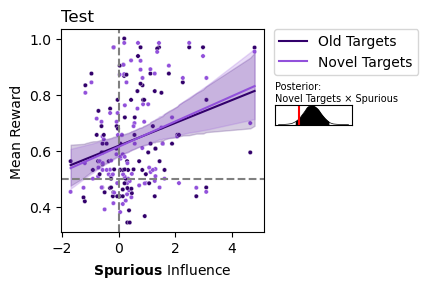

In [79]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(.5, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'spurious',
    y = 'reward',
    hue = 'novel_target',
    palette = NOVELTY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novtarget_by_spurious_summary[novel]

    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['novel_target'] == novel, 'spurious'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_xlabel(r'$\bf{Spurious}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Targets', 'Novel Targets'], loc=(1.05, .775))
ax.set_title('Test', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .18, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_target:spurious'].values.flatten(),
    label = 'Posterior:\nNovel Targets × Spurious',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-novel-target-by-spurious-influence.pdf', bbox_inches='tight')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/2251137556.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


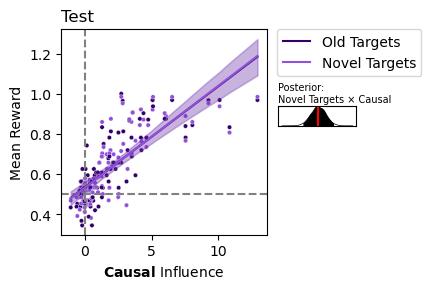

In [80]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(.5, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'causal',
    y = 'reward',
    hue = 'novel_target',
    palette = NOVELTY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novtarget_by_causal_summary[novel]

    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['novel_target'] == novel, 'causal'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_xlabel(r'$\bf{Causal}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Targets', 'Novel Targets'], loc=(1.05, .775))
ax.set_title('Test', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .18, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_target:causal'].values.flatten(),
    label = 'Posterior:\nNovel Targets × Causal',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-novel-target-by-causal-influence.pdf', bbox_inches='tight')

In [81]:
# Summarize data
plot_df = model_df[[
    'id',
    'action',
    'spurious',
    'causal',
    'novel_options',
    'reward'
]]
plot_df = plot_df.groupby([
    'id',
    'action',
    'spurious',
    'causal',
    'novel_options'
])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()
plot_df = plot_df[[
    'id',
    'spurious',
    'causal',
    'novel_options',
    'reward'
]]
plot_df = plot_df.groupby([
    'id',
    'novel_options'
])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
novoptions_by_spurious_summary = data_summary(
    plot_df,
    ['novel_options'],
    'reward',
    x_var = 'spurious',
    seed = 2534,
    fname = f'{FIG_PATH}/stats/novoptions-by-spurious-influence.pkl'
)

# Get mean and 95% HDI for causal influence -> reward gain
novoptions_by_causal_summary = data_summary(
    plot_df,
    ['novel_options'],
    'reward',
    x_var = 'causal',
    seed = 3443,
    fname = f'{FIG_PATH}/stats/novoptions-by-causal-influence.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/4059427282.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


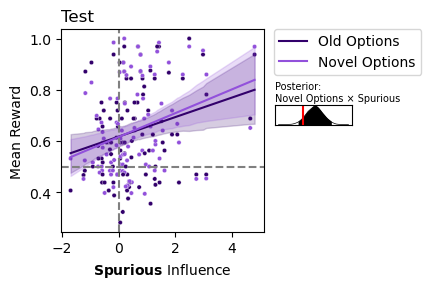

In [82]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(.5, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'spurious',
    y = 'reward',
    hue = 'novel_options',
    palette = NOVELTY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novoptions_by_spurious_summary[novel]

    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['novel_options'] == novel, 'spurious'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_xlabel(r'$\bf{Spurious}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Options', 'Novel Options'], loc=(1.05, .775))
ax.set_title('Test', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .18, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_options:spurious'].values.flatten(),
    label = 'Posterior:\nNovel Options × Spurious',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-novel-options-by-spurious-influence.pdf', bbox_inches='tight')

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_30675/4293396627.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


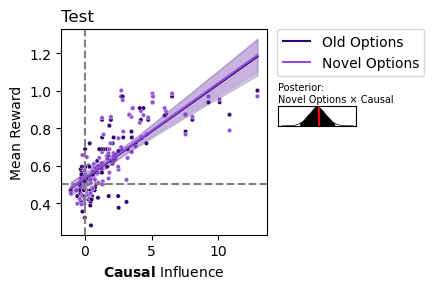

In [83]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(.5, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'causal',
    y = 'reward',
    hue = 'novel_options',
    palette = NOVELTY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novoptions_by_causal_summary[novel]

    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['novel_options'] == novel, 'causal'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_xlabel(r'$\bf{Causal}$ Influence')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Options', 'Novel Options'], loc=(1.05, .775))
ax.set_title('Test', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .18, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_options:causal'].values.flatten(),
    label = 'Posterior:\nNovel Options × Causal',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-novel-options-by-causal-influence.pdf', bbox_inches='tight')

## Behavior by causal-bias parameter fit

### Transition influence by causal-bias parameter fit

In [70]:
# Select participants with feature-based fits only
idx = trans_influence_df['model_label'] == 'ff'
model_df = trans_influence_df.loc[idx]

# Code so that causal = 1
model_df['transition'] = model_df['transition'] == 'causal'

# Fit model with segmentation 
model_preg1_e4 = bmb.Model(
    "coef ~ segmentation*transition + (1|action)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e4 = model_preg1_e4.fit(
    random_seed = 14,
    tune = 2000,
    draws = 2000,
    target_accept = .95
)

# Results
az.summary(fitted_preg1_e4)

Output()

There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|action[1],-0.037,0.376,-0.860,0.729,0.018,0.013,735.0,273.0,1.00
1|action[2],0.034,0.371,-0.727,0.934,0.017,0.013,827.0,282.0,1.00
1|action[3],0.104,0.385,-0.670,0.977,0.019,0.016,813.0,437.0,1.00
1|action_sigma,0.510,0.740,0.000,1.789,0.050,0.046,827.0,436.0,1.00
Intercept,0.875,0.536,-0.301,1.853,0.022,0.015,829.0,286.0,1.01
segmentation,-0.135,0.514,-1.148,0.865,0.009,0.007,3108.0,4180.0,1.00
segmentation:transition,2.638,0.752,1.190,4.125,0.015,0.011,2429.0,3266.0,1.00
sigma,2.344,0.102,2.153,2.549,0.002,0.001,4501.0,4042.0,1.00
transition,1.357,0.575,0.210,2.440,0.012,0.008,2286.0,3523.0,1.00


In [71]:
plot_df = model_df[['id', 'segmentation', 'transition', 'coef']]
plot_df = plot_df.groupby(['id', 'segmentation', 'transition'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
coef_by_bias_summary = data_summary(
    plot_df,
    ['transition'],
    'coef',
    x_var = 'segmentation',
    seed = 32344,
    fname = f'{FIG_PATH}/stats/coef-by-bias.pkl'
)

Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:297: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(post_preds)


Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:297: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(post_preds)


### Training frequency sensitivity by causal-bias parameter fit

In [72]:
# Select participants with feature-based fits only
idx = training_df['model_label'] == 'ff'
model_df = training_df.loc[idx, ['id', 'segmentation', 'freq', 'reward']]

# Fit model with segmentation 
model_preg1_e5 = bmb.Model(
    'reward ~ segmentation*freq + (1|id)',
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e5 = model_preg1_e5.fit(
    random_seed = 15,
    tune = 2000,
    draws = 2000,
    target_accept = .95
)

# Results
az.summary(fitted_preg1_e5)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|id[30579],-0.130,0.095,-0.319,0.056,0.002,0.001,2381.0,4150.0,1.0
1|id[40431],0.303,0.078,0.151,0.455,0.001,0.001,3863.0,4684.0,1.0
1|id[60902],-0.400,0.083,-0.571,-0.243,0.001,0.001,3396.0,5015.0,1.0
1|id[81304],-0.085,0.082,-0.247,0.074,0.002,0.001,2937.0,4620.0,1.0
1|id[108800],-0.244,0.077,-0.389,-0.088,0.001,0.001,4393.0,5378.0,1.0
1|id[121963],-0.072,0.081,-0.235,0.079,0.001,0.001,3249.0,4700.0,1.0
1|id[128037],0.079,0.081,-0.071,0.244,0.001,0.001,3373.0,4702.0,1.0
1|id[202441],0.136,0.086,-0.028,0.308,0.002,0.001,2721.0,5202.0,1.0
1|id[242082],0.206,0.080,0.045,0.357,0.001,0.001,3649.0,4919.0,1.0
1|id[276292],-0.295,0.095,-0.488,-0.118,0.002,0.001,2344.0,4245.0,1.0


In [73]:
# Each participants average reward on frequent and infrequent trials
plot_df = model_df.groupby(['id', 'freq', 'segmentation'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
freq_by_bias_summary = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'segmentation',
    seed = 54322,
    fname = f'{FIG_PATH}/stats/freq-by-bias.pkl'
)

Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:297: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(post_preds)


Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:297: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(post_preds)


### Test (old) frequency sensitivity by causal-bias parameter fit

In [74]:
# Select participants with feature-based fits only
idx = (test_df['model_label'] == 'ff') & test_df['old']
model_df = test_df.loc[idx, ['id', 'segmentation', 'freq', 'reward']]

# Fit model with segmentation 
model_preg1_e6 = bmb.Model(
    'reward ~ segmentation*freq + (1|id)',
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg1_e6 = model_preg1_e6.fit(
    random_seed = 16,
    tune = 2000,
    draws = 2000,
    target_accept = .95
)

# Results
az.summary(fitted_preg1_e6)

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|id[30579],-0.023,0.191,-0.411,0.336,0.002,0.002,6529.0,5728.0,1.0
1|id[40431],0.330,0.182,-0.014,0.700,0.002,0.001,8907.0,5753.0,1.0
1|id[60902],-0.352,0.188,-0.728,-0.003,0.002,0.002,6704.0,5687.0,1.0
1|id[81304],-0.181,0.183,-0.555,0.160,0.002,0.002,7543.0,5631.0,1.0
1|id[108800],-0.232,0.180,-0.582,0.126,0.002,0.002,7533.0,6146.0,1.0
1|id[121963],0.246,0.184,-0.142,0.587,0.002,0.002,7361.0,5021.0,1.0
1|id[128037],-0.352,0.186,-0.732,-0.004,0.002,0.002,7414.0,5859.0,1.0
1|id[202441],-0.016,0.193,-0.379,0.380,0.002,0.002,7839.0,5648.0,1.0
1|id[242082],0.246,0.183,-0.113,0.598,0.002,0.002,7948.0,6129.0,1.0
1|id[276292],-0.112,0.190,-0.480,0.260,0.002,0.002,6311.0,6050.0,1.0


In [75]:
# Each participants average reward on frequent and infrequent trials
plot_df = model_df.groupby(['id', 'freq', 'segmentation'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
test_freq_by_bias_summary = data_summary(
    plot_df,
    ['freq'],
    'reward',
    x_var = 'segmentation',
    seed = 53423,
    fname = f'{FIG_PATH}/stats/test-freq-by-bias.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3056568405.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


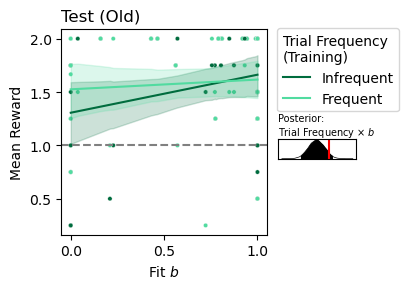

In [76]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'segmentation',
    y = 'reward',
    hue = 'freq',
    palette = FREQUENCY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = test_freq_by_bias_summary[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['freq'] == freq, 'segmentation'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(r'Fit $\it{b}$')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(
    handles[-2:],
    ['Infrequent', 'Frequent'],
    loc = (1.05, .6),
    title = 'Trial Frequency\n(Training)',
    alignment = 'left'
)
ax.set_title('Test (Old)', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .02, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg1_e6.posterior['segmentation:freq'].values.flatten(),
    label = 'Posterior:\nTrial Frequency × ' + r'$\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-reward-by-causal-bias.pdf', bbox_inches='tight')

### Generalization performance by causal-bias parameter fit

In [77]:
idx = (
    (test_df['model_label'] == 'ff') &
    (test_df['n_transitions_to_target'] == 1)
)
model_df = test_df.loc[idx, [
    'id',
    'segmentation',
    'novel_target',
    'novel_options',
    'reward'
]]
model_df = model_df.reset_index(drop=True)

model_preg4_e1 = bmb.Model(
    "reward ~ novel_target*segmentation + novel_options*segmentation + (1|id)",
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg4_e1 = model_preg4_e1.fit(
    random_seed = 4
)
az.summary(fitted_preg4_e1)[-7:]

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.690,0.051,0.588,0.792,0.002,0.001,1080.0,1676.0,1.00
novel_options,0.020,0.028,-0.033,0.078,0.001,0.000,1931.0,2382.0,1.00
novel_options:segmentation,-0.012,0.037,-0.082,0.062,0.001,0.001,1917.0,2506.0,1.00
novel_target,0.037,0.029,-0.018,0.096,0.001,0.000,1968.0,2555.0,1.00
novel_target:segmentation,-0.036,0.037,-0.107,0.039,0.001,0.001,1979.0,2425.0,1.00
segmentation,0.113,0.068,-0.023,0.243,0.002,0.002,959.0,1701.0,1.01
sigma,0.391,0.004,0.383,0.399,0.000,0.000,5632.0,2868.0,1.00


In [78]:
# Each participants average reward on test trials with old versus novel targets trials
plot_df = model_df.groupby(['id', 'novel_options', 'novel_target', 'segmentation'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Get mean and 95% HDI for spurious influence -> reward gain
novel_options_by_bias_summary = data_summary(
    plot_df,
    ['novel_options'],
    'reward',
    x_var = 'segmentation',
    seed = 2243,
    fname = f'{FIG_PATH}/stats/novel-options-by-bias.pkl'
)

# Get mean and 95% HDI for spurious influence -> reward gain
novel_target_by_bias_summary = data_summary(
    plot_df,
    ['novel_target'],
    'reward',
    x_var = 'segmentation',
    seed = 2243,
    fname = f'{FIG_PATH}/stats/novel-target-by-bias.pkl'
)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/1032360459.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


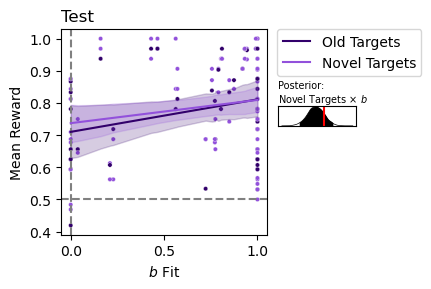

In [79]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot average reward by spurious transition influence and frequency
ax.axhline(.5, c='.5', linestyle='--')
ax.axvline(0, c='.5', linestyle='--')
sns.scatterplot(
    data = plot_df,
    x = 'segmentation',
    y = 'reward',
    hue = 'novel_target',
    palette = NOVELTY_COLORS,
    s = 10,
    zorder = 0,
    ax = ax
)

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novel_target_by_bias_summary[novel]

    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df.loc[plot_df['novel_target'] == novel, 'segmentation'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_xlabel(r'$\it{b}$ Fit')
ax.set_ylabel('Mean Reward')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Targets', 'Novel Targets'], loc=(1.05, .775))
ax.set_title('Test', loc='left')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '40%',
    height = '20%',
    bbox_to_anchor =  (.52, .18, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_target:segmentation'].values.flatten(),
    label = 'Posterior:\nNovel Targets × ' + r'$\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)

fig.tight_layout()
plt.savefig(f'{FIG_PATH}/test-novel-target-by-causal-bias.pdf', bbox_inches='tight')

### Composition spurious predictiveness by causal-bias parameter

In [80]:
idx = (
    (test_df['spurious_trial'] == 1) &
    (test_df['model_label'] == 'ff')
)
model_df = test_df.loc[idx, ['id', 'segmentation', 'comp_spur_pred']]
model_preg7_e1 = bmb.Model(
    'comp_spur_pred ~ segmentation + (1|id)',
    model_df,
    family = 'gaussian',
    link = 'identity'
)
fitted_preg7_e1 = model_preg7_e1.fit(
    random_seed = 7,
    tune = 1000,
    draws = 1000
)
az.summary(fitted_preg7_e1)[-3:]


Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.390,0.099,1.202,1.580,0.002,0.002,1931.0,2777.0,1.0
segmentation,-0.427,0.126,-0.672,-0.181,0.003,0.002,2217.0,2587.0,1.0
sigma,0.671,0.027,0.620,0.725,0.000,0.000,3063.0,2657.0,1.0


In [81]:
# Each participant's average composition spurious predictiveness 
plot_df = model_df.groupby(['id', 'segmentation'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()
plot_df['group'] = 1

# Get mean and 95% HDI for spurious influence -> reward gain
spur_pred_by_bias_summary = data_summary(
    plot_df,
    ['group'],
    'comp_spur_pred',
    x_var = 'segmentation',
    seed = 443232,
    fname = f'{FIG_PATH}/stats/spur-pred-by-bias.pkl'
)[1]


Output()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/3825722027.py:297: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(post_preds)


### Plot together

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_43677/1539653877.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


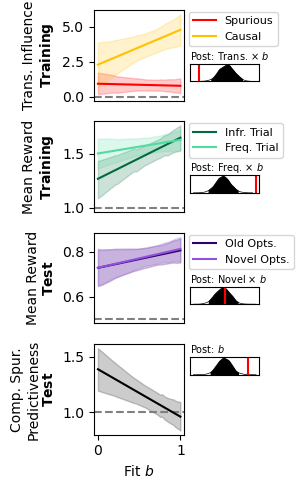

In [82]:
fig, axs = plt.subplots(4, 1, figsize=(2.5, 5))

### Plot causal and spurious transition influence by causal-bias parameter fit

ax = axs[0]
ax.axhline(0, c='.5', linestyle='--')

# Plot means and 95% HDI lines
for transition in [0, 1]: # spurious, causal
    post = coef_by_bias_summary[transition]

    transition = ['spurious', 'causal'][transition]

    # Plot mean
    ax.plot(*post['mean'], color=TRANSITION_COLORS[transition], label=transition)

    # Plot 95% HDI
    x = np.unique(plot_df['segmentation'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=TRANSITION_COLORS[transition])
    
# Format
ax.set_xlabel(None)
ax.set_xticks([])
#ax.set_ylabel('Trans. Influence\n(Training)')
ax.set_ylabel('Trans. Influence\n' + r'$\bf{Training}$')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Spurious', 'Causal'], fontsize=8, loc=(1.05, .6))
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '80%',
    height = '40%',
    bbox_to_anchor =  (.95, 0, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg1_e4.posterior['segmentation:transition'].values.flatten(),
    label = r'Post: Trans. × $\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)

### Plot training frequency sensitivity by causal-bias parameter fit

ax = axs[1]
ax.axhline(1, c='.5', linestyle='--')

# Plot means and 95% HDI lines
for freq in [0, 1]:
    post = freq_by_bias_summary[freq]

    # Plot mean
    ax.plot(*post['mean'], color=FREQUENCY_COLORS[freq], label=freq)

    # Plot 95% HDI
    x = np.unique(plot_df['segmentation'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=FREQUENCY_COLORS[freq])
    
# Format
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_ylabel('Mean Reward\n' + r'$\bf{Training}$')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Infr. Trial', 'Freq. Trial'], fontsize=8, loc=(1.05, .6))
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '80%',
    height = '40%',
    bbox_to_anchor =  (.95, 0, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg1_e5.posterior['segmentation:freq'].values.flatten(),
    label = r'Post: Freq. × $\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)




### Plot options generalization by causal-bias parameter fit 

ax = axs[2]
ax.axhline(.5, c='.5', linestyle='--')

# Plot means and 95% HDI lines
for novel in [0, 1]:
    post = novel_options_by_bias_summary[novel]
    
    # Plot mean
    ax.plot(*post['mean'], color=NOVELTY_COLORS[novel], label=novel)

    # Plot 95% HDI
    x = np.unique(plot_df['segmentation'])
    ax.fill_between(x, *post['hdi'].T, alpha=.2, color=NOVELTY_COLORS[novel])
    
# Format
ax.set_ylabel('Mean Reward\n' + r'$\bf{Test}$')
handles = ax.get_legend_handles_labels()[0]
ax.legend(handles[-2:], ['Old Opts.', 'Novel Opts.'], fontsize=8, loc=(1.05, .6))
ax.set_xticks([])
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '80%',
    height = '40%',
    bbox_to_anchor =  (.95, 0, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg4_e1.posterior['novel_options:segmentation'].values.flatten(),
    label = r'Post: Novel × $\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)



### Plot composition spurious predictiveness by causal-bias parameter fit

ax = axs[3]

# Plot average reward by spurious transition influence and frequency
ax.axhline(1, c='.5', linestyle='--')

# Plot mean
ax.plot(*spur_pred_by_bias_summary['mean'], color='k')

# Plot 95% HDI
x = np.unique(plot_df['segmentation'])
ax.fill_between(x, *spur_pred_by_bias_summary['hdi'].T, alpha=.2, color='k')
    
# Format
ax.set_xlabel(r'Fit $\it{b}$')
ax.set_ylabel('Comp. Spur.\nPredictiveness\n' + r'$\bf{Test}$')
set_axis_ratio(ax)

# Inset interaction posterior plot with HDI
inset_ax = inset_axes(
    ax,
    width = '80%',
    height = '40%',
    bbox_to_anchor =  (.95, .45, .95, 0.48),
    bbox_transform = ax.transAxes
)
plot_hdi(
    inset_ax,
    fitted_preg7_e1.posterior['segmentation'].values.flatten(),
    label = r'Post: $\it{b}$',
    label_loc = 'left',
    chance_color = 'red'
)


# Save
fig.tight_layout()
plt.savefig(f'{FIG_PATH}/bias-predictions.pdf', bbox_inches='tight')